## Bike Rental Prediction with ANN: Learning Rate = 1e-3

This project aims at predicting bike rental rate based on weather and holiday information. The dataset contains hourly count of public bikes rented in Seoul Bike Sharing System, along with the corresponding weather data and holidays information, and is available at: https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv

In this notebook, we train an artificial neural network with learning rate = 1e-3 to make predictions

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
# reading feature-engineered saved data file
df = pd.read_pickle('data_feat_eng.pkl')

In [3]:
df.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Month,Year,No Holiday,Funct_Day
0,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,12,0,1,1
1,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,12,0,1,1
2,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,12,0,1,1
3,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,12,0,1,1
4,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,12,0,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rented Bike Count          8760 non-null   int64  
 1   Hour                       8760 non-null   int64  
 2   Temperature(°C)            8760 non-null   float64
 3   Humidity(%)                8760 non-null   int64  
 4   Wind speed (m/s)           8760 non-null   float64
 5   Visibility (10m)           8760 non-null   int64  
 6   Dew point temperature(°C)  8760 non-null   float64
 7   Solar Radiation (MJ/m2)    8760 non-null   int64  
 8   Rainfall(mm)               8760 non-null   int64  
 9   Snowfall (cm)              8760 non-null   int64  
 10  Month                      8760 non-null   int64  
 11  Year                       8760 non-null   int64  
 12  No Holiday                 8760 non-null   uint8  
 13  Funct_Day                  8760 non-null   uint8

There are 13 numerical features

### Train-Test Splitting of Data

In [5]:
# features and labels are singled out of the dataframe

X = df.drop(['Rented Bike Count'],axis=1)
y = df['Rented Bike Count']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### Data pre-processing

Pairwise correlation of features, if high, may suggest throwing away some of the features

Text(0.5, 1.0, 'Pairwise Correlation of Featues')

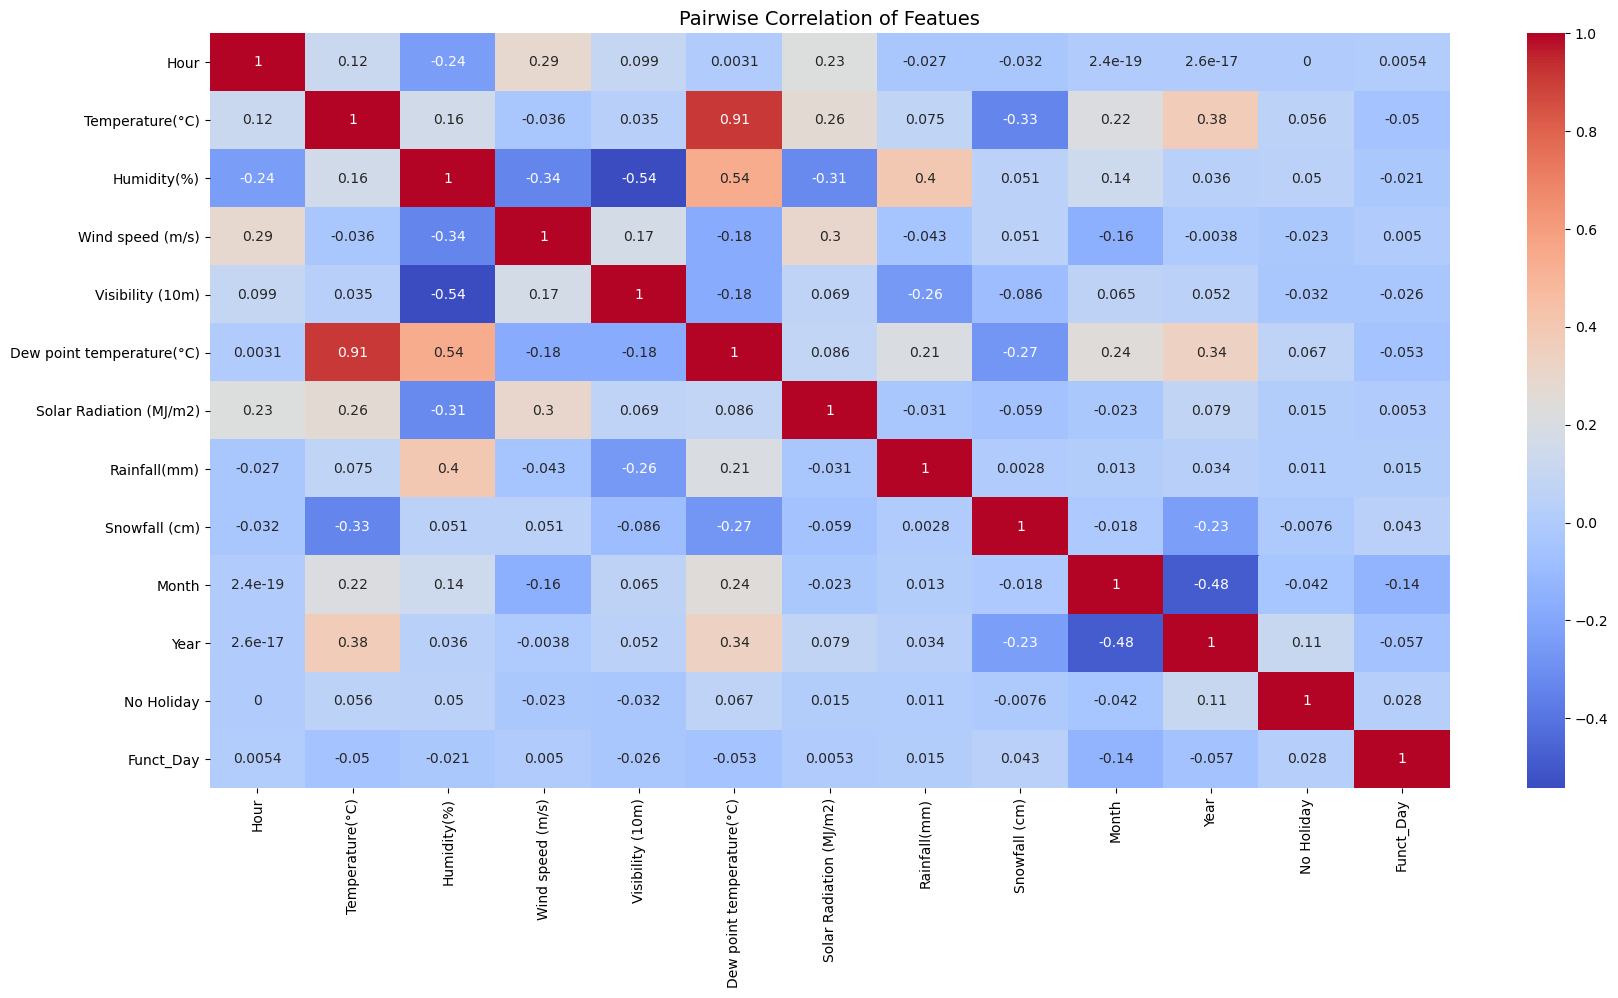

In [6]:
# pairwise correlation of featues
plt.figure(figsize=(20,10),dpi=100)
sns.heatmap(X.corr(),cmap='coolwarm',annot=True)
plt.title('Pairwise Correlation of Featues', fontsize=14)

There is a single highly correlated pair. We may need to perform PCA

#### Principal Component Analysis

In [7]:
from sklearn.preprocessing import MinMaxScaler

# feature scaling
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

To see how many principal components may be needed, let us plot cumulative explained variance

Text(0, 0.5, 'Cumulative explained variance')

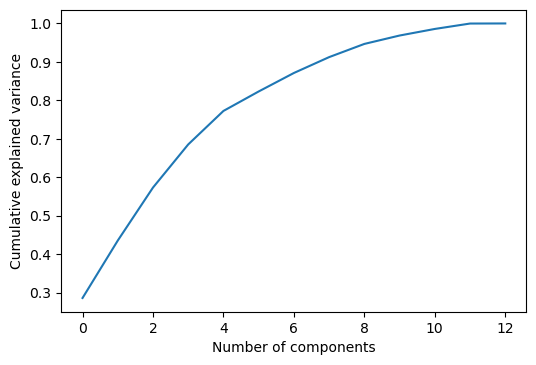

In [8]:
from sklearn.decomposition import PCA

# making the list of cumulative explained variance
pca = PCA().fit(X_train)
cumsum_list = pca.explained_variance_ratio_.cumsum()

# making the plot of cumulative explained variance
plt.figure(dpi=100)
plt.plot(cumsum_list)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

We will retain as many principal components as account for 99% cumulative variance:

In [9]:
pc_model = PCA(n_components=0.99, svd_solver='full')
pc_model.fit(X_train)
pc_model.n_components_ 

12

This rids of one more feature. Now we select out the proncipal components

In [10]:
# principal component selection
X_train = pc_model.fit_transform(X_train)
X_test = pc_model.transform(X_test)

Next we create an artificial neural network for training

### Creating the Model

In [11]:
# import tensorflow and check version
import tensorflow as tf
tf.__version__

'2.4.1'

In [12]:
# imports for network architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [13]:
def create_ann():
    '''This function creates an ANN model'''
    
    # start neural network
    model = Sequential()
    
    model.add(Dense(12, activation='relu')) # input layer
    
    model.add(Dense(12, activation='relu')) # first hidden layer
    
    model.add(Dense(12, activation='relu')) # second hidden layer
    
    model.add(Dense(1))                    # output layer
    
    # compile neural network
    opt = tf.keras.optimizers.Adam(learning_rate=0.001) # default learning_rate = 0.001
    model.compile(optimizer=opt,loss='mae')
    
    # return compiled network
    return model

In [14]:
# model created
ann = create_ann()

Now we will train the ANN with validation_split = 0.1, batch_size = 128, for 10_000 epochs

In [15]:
import time
t1 = time.time()

# training the model
ann.fit(x=X_train, y=y_train, validation_split=0.1, batch_size=128, epochs=10_000)

t2 = time.time()

Epoch 1/10000
50/50 [==============================] - 3s 35ms/step - loss: 705.3703 - val_loss: 697.2348
Epoch 2/10000
50/50 [==============================] - 0s 2ms/step - loss: 708.2029 - val_loss: 694.4995
Epoch 3/10000
50/50 [==============================] - 0s 2ms/step - loss: 704.8488 - val_loss: 686.3171
Epoch 4/10000
50/50 [==============================] - 0s 2ms/step - loss: 698.5307 - val_loss: 666.4743
Epoch 5/10000
50/50 [==============================] - 0s 2ms/step - loss: 668.4328 - val_loss: 629.6020
Epoch 6/10000
50/50 [==============================] - 0s 2ms/step - loss: 622.2104 - val_loss: 569.9464
Epoch 7/10000
50/50 [==============================] - 0s 2ms/step - loss: 577.0077 - val_loss: 495.4329
Epoch 8/10000
50/50 [==============================] - 0s 2ms/step - loss: 475.6283 - val_loss: 423.8570
Epoch 9/10000
50/50 [==============================] - 0s 2ms/step - loss: 410.4666 - val_loss: 378.9370
Epoch 10/10000
50/50 [==============================] 

50/50 [==============================] - 0s 2ms/step - loss: 238.3207 - val_loss: 247.9698
Epoch 79/10000
50/50 [==============================] - 0s 2ms/step - loss: 240.9103 - val_loss: 247.5175
Epoch 80/10000
50/50 [==============================] - 0s 2ms/step - loss: 248.4484 - val_loss: 247.4812
Epoch 81/10000
50/50 [==============================] - 0s 2ms/step - loss: 245.7856 - val_loss: 247.2605
Epoch 82/10000
50/50 [==============================] - 0s 2ms/step - loss: 244.5913 - val_loss: 247.2009
Epoch 83/10000
50/50 [==============================] - 0s 2ms/step - loss: 241.9077 - val_loss: 247.1722
Epoch 84/10000
50/50 [==============================] - 0s 2ms/step - loss: 246.3620 - val_loss: 246.9755
Epoch 85/10000
50/50 [==============================] - 0s 2ms/step - loss: 250.1949 - val_loss: 246.7905
Epoch 86/10000
50/50 [==============================] - 0s 2ms/step - loss: 246.2389 - val_loss: 246.7039
Epoch 87/10000
50/50 [==============================] - 0s 2m

Epoch 155/10000
50/50 [==============================] - 0s 2ms/step - loss: 230.2249 - val_loss: 238.2451
Epoch 156/10000
50/50 [==============================] - 0s 3ms/step - loss: 233.1030 - val_loss: 237.9556
Epoch 157/10000
50/50 [==============================] - 0s 3ms/step - loss: 235.2604 - val_loss: 238.3606
Epoch 158/10000
50/50 [==============================] - 0s 3ms/step - loss: 238.2395 - val_loss: 237.7320
Epoch 159/10000
50/50 [==============================] - 0s 3ms/step - loss: 240.2591 - val_loss: 237.6996
Epoch 160/10000
50/50 [==============================] - 0s 3ms/step - loss: 223.7387 - val_loss: 237.0248
Epoch 161/10000
50/50 [==============================] - 0s 3ms/step - loss: 234.5224 - val_loss: 237.1903
Epoch 162/10000
50/50 [==============================] - 0s 3ms/step - loss: 238.2972 - val_loss: 237.2519
Epoch 163/10000
50/50 [==============================] - 0s 3ms/step - loss: 232.4946 - val_loss: 237.5889
Epoch 164/10000
50/50 [==============

50/50 [==============================] - 0s 3ms/step - loss: 226.2912 - val_loss: 227.7937
Epoch 232/10000
50/50 [==============================] - 0s 3ms/step - loss: 223.9609 - val_loss: 227.6094
Epoch 233/10000
50/50 [==============================] - 0s 3ms/step - loss: 217.3543 - val_loss: 226.6996
Epoch 234/10000
50/50 [==============================] - 0s 3ms/step - loss: 221.5043 - val_loss: 227.3096
Epoch 235/10000
50/50 [==============================] - 0s 3ms/step - loss: 219.5835 - val_loss: 226.6758
Epoch 236/10000
50/50 [==============================] - 0s 3ms/step - loss: 216.1071 - val_loss: 226.4581
Epoch 237/10000
50/50 [==============================] - 0s 3ms/step - loss: 222.0041 - val_loss: 228.1564
Epoch 238/10000
50/50 [==============================] - 0s 3ms/step - loss: 224.7581 - val_loss: 227.0590
Epoch 239/10000
50/50 [==============================] - 0s 3ms/step - loss: 221.2390 - val_loss: 226.7086
Epoch 240/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 212.6563 - val_loss: 219.5705
Epoch 308/10000
50/50 [==============================] - 0s 3ms/step - loss: 219.0001 - val_loss: 219.2098
Epoch 309/10000
50/50 [==============================] - 0s 3ms/step - loss: 214.6134 - val_loss: 219.1931
Epoch 310/10000
50/50 [==============================] - 0s 3ms/step - loss: 208.5736 - val_loss: 219.7782
Epoch 311/10000
50/50 [==============================] - 0s 3ms/step - loss: 209.1333 - val_loss: 219.9456
Epoch 312/10000
50/50 [==============================] - 0s 3ms/step - loss: 211.1456 - val_loss: 219.1150
Epoch 313/10000
50/50 [==============================] - 0s 3ms/step - loss: 212.0442 - val_loss: 219.4476
Epoch 314/10000
50/50 [==============================] - 0s 3ms/step - loss: 215.0368 - val_loss: 218.9741
Epoch 315/10000
50/50 [==============================] - 0s 3ms/step - loss: 213.6490 - val_loss: 219.3597
Epoch 316/10000
50/50 [==============================

50/50 [==============================] - 0s 4ms/step - loss: 201.9422 - val_loss: 211.2149
Epoch 384/10000
50/50 [==============================] - 0s 3ms/step - loss: 207.0852 - val_loss: 210.1623
Epoch 385/10000
50/50 [==============================] - 0s 3ms/step - loss: 205.5089 - val_loss: 210.7102
Epoch 386/10000
50/50 [==============================] - 0s 4ms/step - loss: 206.9189 - val_loss: 210.4333
Epoch 387/10000
50/50 [==============================] - 0s 4ms/step - loss: 205.2551 - val_loss: 209.7390
Epoch 388/10000
50/50 [==============================] - 0s 4ms/step - loss: 197.9695 - val_loss: 208.9333
Epoch 389/10000
50/50 [==============================] - 0s 3ms/step - loss: 205.9051 - val_loss: 208.8801
Epoch 390/10000
50/50 [==============================] - 0s 3ms/step - loss: 202.5320 - val_loss: 209.0174
Epoch 391/10000
50/50 [==============================] - 0s 3ms/step - loss: 196.5733 - val_loss: 209.0124
Epoch 392/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 186.8614 - val_loss: 195.1559
Epoch 460/10000
50/50 [==============================] - 0s 3ms/step - loss: 189.5761 - val_loss: 195.1316
Epoch 461/10000
50/50 [==============================] - 0s 3ms/step - loss: 189.8922 - val_loss: 194.8626
Epoch 462/10000
50/50 [==============================] - 0s 3ms/step - loss: 191.3994 - val_loss: 194.7913
Epoch 463/10000
50/50 [==============================] - 0s 3ms/step - loss: 189.8106 - val_loss: 194.5661
Epoch 464/10000
50/50 [==============================] - 0s 3ms/step - loss: 187.4413 - val_loss: 194.2218
Epoch 465/10000
50/50 [==============================] - 0s 3ms/step - loss: 185.8630 - val_loss: 194.6562
Epoch 466/10000
50/50 [==============================] - 0s 3ms/step - loss: 183.8665 - val_loss: 194.2521
Epoch 467/10000
50/50 [==============================] - 0s 3ms/step - loss: 186.2856 - val_loss: 193.6414
Epoch 468/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 176.6014 - val_loss: 184.5457
Epoch 536/10000
50/50 [==============================] - 0s 3ms/step - loss: 178.3396 - val_loss: 184.8246
Epoch 537/10000
50/50 [==============================] - 0s 3ms/step - loss: 179.4940 - val_loss: 184.4296
Epoch 538/10000
50/50 [==============================] - 0s 3ms/step - loss: 183.0639 - val_loss: 184.1642
Epoch 539/10000
50/50 [==============================] - 0s 3ms/step - loss: 181.2545 - val_loss: 184.1516
Epoch 540/10000
50/50 [==============================] - 0s 3ms/step - loss: 173.5690 - val_loss: 183.8272
Epoch 541/10000
50/50 [==============================] - 0s 3ms/step - loss: 176.1234 - val_loss: 184.3784
Epoch 542/10000
50/50 [==============================] - 0s 3ms/step - loss: 179.4718 - val_loss: 184.7048
Epoch 543/10000
50/50 [==============================] - 0s 3ms/step - loss: 180.5675 - val_loss: 183.8309
Epoch 544/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 170.5713 - val_loss: 172.2892
Epoch 612/10000
50/50 [==============================] - 0s 3ms/step - loss: 171.8632 - val_loss: 172.4004
Epoch 613/10000
50/50 [==============================] - 0s 3ms/step - loss: 172.3128 - val_loss: 171.6417
Epoch 614/10000
50/50 [==============================] - 0s 3ms/step - loss: 168.6895 - val_loss: 171.9475
Epoch 615/10000
50/50 [==============================] - 0s 3ms/step - loss: 169.8034 - val_loss: 172.2596
Epoch 616/10000
50/50 [==============================] - 0s 3ms/step - loss: 171.8865 - val_loss: 171.7139
Epoch 617/10000
50/50 [==============================] - 0s 3ms/step - loss: 170.8567 - val_loss: 171.1844
Epoch 618/10000
50/50 [==============================] - 0s 3ms/step - loss: 171.2786 - val_loss: 171.2792
Epoch 619/10000
50/50 [==============================] - 0s 3ms/step - loss: 169.6602 - val_loss: 171.8531
Epoch 620/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 164.2083 - val_loss: 162.9168
Epoch 688/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.7929 - val_loss: 162.4199
Epoch 689/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.4572 - val_loss: 162.2328
Epoch 690/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.9564 - val_loss: 162.2236
Epoch 691/10000
50/50 [==============================] - 0s 3ms/step - loss: 165.4528 - val_loss: 162.2845
Epoch 692/10000
50/50 [==============================] - 0s 4ms/step - loss: 170.9480 - val_loss: 162.0252
Epoch 693/10000
50/50 [==============================] - 0s 3ms/step - loss: 165.9989 - val_loss: 162.0666
Epoch 694/10000
50/50 [==============================] - 0s 4ms/step - loss: 165.1215 - val_loss: 162.3978
Epoch 695/10000
50/50 [==============================] - 0s 4ms/step - loss: 165.0398 - val_loss: 164.3194
Epoch 696/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 164.2685 - val_loss: 157.2761
Epoch 764/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.8619 - val_loss: 156.9760
Epoch 765/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.8145 - val_loss: 157.0875
Epoch 766/10000
50/50 [==============================] - 0s 3ms/step - loss: 164.0326 - val_loss: 156.9989
Epoch 767/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.1969 - val_loss: 157.8917
Epoch 768/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.1641 - val_loss: 156.9114
Epoch 769/10000
50/50 [==============================] - 0s 3ms/step - loss: 166.5658 - val_loss: 156.6814
Epoch 770/10000
50/50 [==============================] - 0s 4ms/step - loss: 164.2779 - val_loss: 156.3614
Epoch 771/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.7395 - val_loss: 156.6479
Epoch 772/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 166.0186 - val_loss: 154.9714
Epoch 840/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.4750 - val_loss: 154.7178
Epoch 841/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.1712 - val_loss: 154.9533
Epoch 842/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.1983 - val_loss: 155.1073
Epoch 843/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.6220 - val_loss: 156.3428
Epoch 844/10000
50/50 [==============================] - 0s 3ms/step - loss: 165.1043 - val_loss: 154.7375
Epoch 845/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.4324 - val_loss: 155.3125
Epoch 846/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.7579 - val_loss: 154.4912
Epoch 847/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.8077 - val_loss: 156.1569
Epoch 848/10000
50/50 [==============================

50/50 [==============================] - 0s 3ms/step - loss: 161.5914 - val_loss: 154.3525
Epoch 916/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.3989 - val_loss: 155.1992
Epoch 917/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.5353 - val_loss: 154.1360
Epoch 918/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.6732 - val_loss: 153.6281
Epoch 919/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.7997 - val_loss: 153.7484
Epoch 920/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.1408 - val_loss: 153.9935
Epoch 921/10000
50/50 [==============================] - 0s 3ms/step - loss: 163.6106 - val_loss: 154.0011
Epoch 922/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.3667 - val_loss: 153.9931
Epoch 923/10000
50/50 [==============================] - 0s 3ms/step - loss: 162.3336 - val_loss: 153.8658
Epoch 924/10000
50/50 [==============================

50/50 [==============================] - 0s 10ms/step - loss: 158.1088 - val_loss: 154.0068
Epoch 992/10000
50/50 [==============================] - 0s 8ms/step - loss: 157.3878 - val_loss: 153.9073
Epoch 993/10000
50/50 [==============================] - 0s 6ms/step - loss: 161.2053 - val_loss: 154.7395
Epoch 994/10000
50/50 [==============================] - 0s 6ms/step - loss: 160.5190 - val_loss: 153.8890
Epoch 995/10000
50/50 [==============================] - 0s 9ms/step - loss: 154.4454 - val_loss: 153.1615
Epoch 996/10000
50/50 [==============================] - 0s 6ms/step - loss: 166.2618 - val_loss: 153.0201
Epoch 997/10000
50/50 [==============================] - 0s 5ms/step - loss: 158.5600 - val_loss: 153.2681
Epoch 998/10000
50/50 [==============================] - 0s 5ms/step - loss: 160.3379 - val_loss: 153.3843
Epoch 999/10000
50/50 [==============================] - 0s 5ms/step - loss: 161.6586 - val_loss: 153.9192
Epoch 1000/10000
50/50 [============================

Epoch 1067/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.9030 - val_loss: 152.4662
Epoch 1068/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.3332 - val_loss: 152.8362
Epoch 1069/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.6560 - val_loss: 152.8730
Epoch 1070/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.4693 - val_loss: 152.5824
Epoch 1071/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.1178 - val_loss: 152.4330
Epoch 1072/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.6155 - val_loss: 152.6142
Epoch 1073/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.5892 - val_loss: 152.5939
Epoch 1074/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.6608 - val_loss: 152.8148
Epoch 1075/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.4180 - val_loss: 152.9875
Epoch 1076/10000
50/50 [====

Epoch 1143/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.5450 - val_loss: 151.8681
Epoch 1144/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.2347 - val_loss: 151.8499
Epoch 1145/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.6681 - val_loss: 151.7755
Epoch 1146/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.0241 - val_loss: 152.7529
Epoch 1147/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.4085 - val_loss: 151.7274
Epoch 1148/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.4544 - val_loss: 151.6014
Epoch 1149/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.3249 - val_loss: 151.7842
Epoch 1150/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.6045 - val_loss: 151.4501
Epoch 1151/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.9900 - val_loss: 153.1216
Epoch 1152/10000
50/50 [====

Epoch 1219/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.8899 - val_loss: 152.5054
Epoch 1220/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.4997 - val_loss: 152.2740
Epoch 1221/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.1463 - val_loss: 153.8552
Epoch 1222/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.6989 - val_loss: 152.0674
Epoch 1223/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.8743 - val_loss: 151.8642
Epoch 1224/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.2879 - val_loss: 152.2283
Epoch 1225/10000
50/50 [==============================] - 0s 3ms/step - loss: 160.9057 - val_loss: 151.6450
Epoch 1226/10000
50/50 [==============================] - 0s 3ms/step - loss: 161.3520 - val_loss: 151.9616
Epoch 1227/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.6690 - val_loss: 152.1472
Epoch 1228/10000
50/50 [====

Epoch 1295/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.9478 - val_loss: 151.5282
Epoch 1296/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.7549 - val_loss: 151.3581
Epoch 1297/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.3035 - val_loss: 151.9906
Epoch 1298/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.0706 - val_loss: 152.4045
Epoch 1299/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.8118 - val_loss: 152.6857
Epoch 1300/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.7322 - val_loss: 153.0401
Epoch 1301/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.5894 - val_loss: 151.4833
Epoch 1302/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.5680 - val_loss: 152.0712
Epoch 1303/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.4501 - val_loss: 151.6755
Epoch 1304/10000
50/50 [====

Epoch 1371/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.2131 - val_loss: 152.2344
Epoch 1372/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.2897 - val_loss: 151.8253
Epoch 1373/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.1547 - val_loss: 151.5028
Epoch 1374/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.2374 - val_loss: 151.4788
Epoch 1375/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.3869 - val_loss: 151.4264
Epoch 1376/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.1646 - val_loss: 152.3672
Epoch 1377/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.5172 - val_loss: 151.1442
Epoch 1378/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.4974 - val_loss: 151.8773
Epoch 1379/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.0216 - val_loss: 152.4909
Epoch 1380/10000
50/50 [====

Epoch 1447/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.8002 - val_loss: 151.1504
Epoch 1448/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.5848 - val_loss: 151.7848
Epoch 1449/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.3024 - val_loss: 151.7972
Epoch 1450/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.3163 - val_loss: 152.4434
Epoch 1451/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.6371 - val_loss: 151.7432
Epoch 1452/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.6078 - val_loss: 152.0923
Epoch 1453/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.9261 - val_loss: 151.3627
Epoch 1454/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.4751 - val_loss: 151.2755
Epoch 1455/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.9397 - val_loss: 151.3888
Epoch 1456/10000
50/50 [====

50/50 [==============================] - 0s 3ms/step - loss: 155.7912 - val_loss: 150.9976
Epoch 1523/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.9856 - val_loss: 151.2809
Epoch 1524/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.0647 - val_loss: 150.8719
Epoch 1525/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.0962 - val_loss: 151.3515
Epoch 1526/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.0790 - val_loss: 152.1048
Epoch 1527/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.7913 - val_loss: 150.9311
Epoch 1528/10000
50/50 [==============================] - 0s 4ms/step - loss: 160.1932 - val_loss: 151.2841
Epoch 1529/10000
50/50 [==============================] - 0s 5ms/step - loss: 150.7262 - val_loss: 150.7884
Epoch 1530/10000
50/50 [==============================] - 0s 5ms/step - loss: 157.3468 - val_loss: 150.3908
Epoch 1531/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 157.0919 - val_loss: 150.5068
Epoch 1599/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.7553 - val_loss: 150.4451
Epoch 1600/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.9946 - val_loss: 150.4565
Epoch 1601/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.9097 - val_loss: 150.7346
Epoch 1602/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.1107 - val_loss: 150.5469
Epoch 1603/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.2216 - val_loss: 150.2764
Epoch 1604/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.6328 - val_loss: 151.5077
Epoch 1605/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.6928 - val_loss: 150.2821
Epoch 1606/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.3675 - val_loss: 152.4226
Epoch 1607/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 153.7069 - val_loss: 150.8042
Epoch 1675/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.0601 - val_loss: 150.5545
Epoch 1676/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.1246 - val_loss: 150.6621
Epoch 1677/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.0770 - val_loss: 150.5076
Epoch 1678/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.2132 - val_loss: 150.7195
Epoch 1679/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.2292 - val_loss: 151.1530
Epoch 1680/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.9800 - val_loss: 150.2466
Epoch 1681/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.1390 - val_loss: 150.6661
Epoch 1682/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.7825 - val_loss: 150.7160
Epoch 1683/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 151.7552 - val_loss: 150.3093
Epoch 1751/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.3377 - val_loss: 151.7026
Epoch 1752/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.7807 - val_loss: 150.7106
Epoch 1753/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.0965 - val_loss: 150.7671
Epoch 1754/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.4748 - val_loss: 150.7737
Epoch 1755/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.8275 - val_loss: 151.4591
Epoch 1756/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.8409 - val_loss: 150.2220
Epoch 1757/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.9081 - val_loss: 150.6078
Epoch 1758/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.2934 - val_loss: 150.7298
Epoch 1759/10000
50/50 [=====================

50/50 [==============================] - 0s 5ms/step - loss: 155.9916 - val_loss: 150.3562
Epoch 1827/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.1012 - val_loss: 150.2689
Epoch 1828/10000
50/50 [==============================] - 0s 5ms/step - loss: 154.7565 - val_loss: 150.9331
Epoch 1829/10000
50/50 [==============================] - 0s 5ms/step - loss: 152.2290 - val_loss: 150.5825
Epoch 1830/10000
50/50 [==============================] - 0s 5ms/step - loss: 155.7673 - val_loss: 150.5576
Epoch 1831/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.2709 - val_loss: 150.4636
Epoch 1832/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.1871 - val_loss: 150.5283
Epoch 1833/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.4147 - val_loss: 150.8720
Epoch 1834/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.8019 - val_loss: 150.3353
Epoch 1835/10000
50/50 [=====================

Epoch 1902/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.4491 - val_loss: 150.5882
Epoch 1903/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.0439 - val_loss: 149.9842
Epoch 1904/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.6940 - val_loss: 149.9132
Epoch 1905/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.8681 - val_loss: 150.3162
Epoch 1906/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.6973 - val_loss: 150.0674
Epoch 1907/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.5003 - val_loss: 150.1824
Epoch 1908/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.3159 - val_loss: 150.0351
Epoch 1909/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.4281 - val_loss: 151.2958
Epoch 1910/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.9488 - val_loss: 150.0855
Epoch 1911/10000
50/50 [====

Epoch 1978/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.3508 - val_loss: 150.1706
Epoch 1979/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.5611 - val_loss: 150.2569
Epoch 1980/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.2916 - val_loss: 150.4089
Epoch 1981/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.0130 - val_loss: 149.9251
Epoch 1982/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.4617 - val_loss: 149.9381
Epoch 1983/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.9384 - val_loss: 149.9709
Epoch 1984/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.9067 - val_loss: 150.0363
Epoch 1985/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.7816 - val_loss: 149.8461
Epoch 1986/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.3065 - val_loss: 149.9652
Epoch 1987/10000
50/50 [====

Epoch 2054/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.6080 - val_loss: 150.0058
Epoch 2055/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.4436 - val_loss: 150.0430
Epoch 2056/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.6205 - val_loss: 150.3673
Epoch 2057/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.5842 - val_loss: 149.6018
Epoch 2058/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.0358 - val_loss: 149.5492
Epoch 2059/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.9464 - val_loss: 149.6486
Epoch 2060/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.0421 - val_loss: 149.7188
Epoch 2061/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.1566 - val_loss: 149.5651
Epoch 2062/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.8057 - val_loss: 149.5584
Epoch 2063/10000
50/50 [====

Epoch 2130/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.3126 - val_loss: 150.4034
Epoch 2131/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.2519 - val_loss: 150.7658
Epoch 2132/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.2967 - val_loss: 149.2842
Epoch 2133/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.3394 - val_loss: 149.8988
Epoch 2134/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.6697 - val_loss: 150.2337
Epoch 2135/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.6974 - val_loss: 149.7709
Epoch 2136/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.8211 - val_loss: 149.5249
Epoch 2137/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.9972 - val_loss: 149.5925
Epoch 2138/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.6960 - val_loss: 149.4536
Epoch 2139/10000
50/50 [====

Epoch 2206/10000
50/50 [==============================] - 0s 5ms/step - loss: 152.5203 - val_loss: 149.5650
Epoch 2207/10000
50/50 [==============================] - 0s 5ms/step - loss: 154.3008 - val_loss: 150.5343
Epoch 2208/10000
50/50 [==============================] - 0s 5ms/step - loss: 153.3082 - val_loss: 150.9687
Epoch 2209/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.7484 - val_loss: 149.4336
Epoch 2210/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.2685 - val_loss: 149.4596
Epoch 2211/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.9653 - val_loss: 149.9144
Epoch 2212/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.7787 - val_loss: 149.5834
Epoch 2213/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.6530 - val_loss: 149.2470
Epoch 2214/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.1949 - val_loss: 149.6168
Epoch 2215/10000
50/50 [====

Epoch 2282/10000
50/50 [==============================] - 0s 6ms/step - loss: 150.6711 - val_loss: 149.3491
Epoch 2283/10000
50/50 [==============================] - 0s 5ms/step - loss: 154.9392 - val_loss: 149.2764
Epoch 2284/10000
50/50 [==============================] - 0s 5ms/step - loss: 153.1846 - val_loss: 149.3564
Epoch 2285/10000
50/50 [==============================] - 0s 6ms/step - loss: 151.1330 - val_loss: 149.4326
Epoch 2286/10000
50/50 [==============================] - 0s 6ms/step - loss: 156.0750 - val_loss: 149.3888
Epoch 2287/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.6410 - val_loss: 149.6442
Epoch 2288/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.6407 - val_loss: 149.2700
Epoch 2289/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.9525 - val_loss: 149.4572
Epoch 2290/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.1684 - val_loss: 149.3573
Epoch 2291/10000
50/50 [====

Epoch 2358/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.5115 - val_loss: 149.2466
Epoch 2359/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.8054 - val_loss: 149.2452
Epoch 2360/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.5734 - val_loss: 149.5145
Epoch 2361/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.0653 - val_loss: 149.3271
Epoch 2362/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.1828 - val_loss: 149.1854
Epoch 2363/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.7078 - val_loss: 149.5798
Epoch 2364/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.6025 - val_loss: 149.4011
Epoch 2365/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.6755 - val_loss: 149.4631
Epoch 2366/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.1461 - val_loss: 149.8873
Epoch 2367/10000
50/50 [====

Epoch 2434/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.3381 - val_loss: 149.3174
Epoch 2435/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.8907 - val_loss: 150.0225
Epoch 2436/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.0394 - val_loss: 151.0812
Epoch 2437/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.9502 - val_loss: 148.8122
Epoch 2438/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.3784 - val_loss: 149.1403
Epoch 2439/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.9540 - val_loss: 149.1371
Epoch 2440/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.3896 - val_loss: 148.9663
Epoch 2441/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.1092 - val_loss: 149.3580
Epoch 2442/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.3499 - val_loss: 149.0051
Epoch 2443/10000
50/50 [====

Epoch 2510/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.6148 - val_loss: 149.0851
Epoch 2511/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.0623 - val_loss: 149.3353
Epoch 2512/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.6873 - val_loss: 148.6956
Epoch 2513/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.0151 - val_loss: 148.5250
Epoch 2514/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.6779 - val_loss: 148.5691
Epoch 2515/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.2665 - val_loss: 148.9045
Epoch 2516/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.5392 - val_loss: 148.5409
Epoch 2517/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.5351 - val_loss: 149.2393
Epoch 2518/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.1178 - val_loss: 148.9635
Epoch 2519/10000
50/50 [====

50/50 [==============================] - 0s 5ms/step - loss: 149.5672 - val_loss: 148.7466
Epoch 2586/10000
50/50 [==============================] - 0s 5ms/step - loss: 154.2788 - val_loss: 148.8084
Epoch 2587/10000
50/50 [==============================] - 0s 5ms/step - loss: 153.5430 - val_loss: 148.6727
Epoch 2588/10000
50/50 [==============================] - 0s 5ms/step - loss: 154.3093 - val_loss: 148.7028
Epoch 2589/10000
50/50 [==============================] - 0s 5ms/step - loss: 152.3178 - val_loss: 148.6937
Epoch 2590/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.8052 - val_loss: 148.8626
Epoch 2591/10000
50/50 [==============================] - 0s 5ms/step - loss: 151.8807 - val_loss: 148.9280
Epoch 2592/10000
50/50 [==============================] - 0s 5ms/step - loss: 152.5693 - val_loss: 148.6268
Epoch 2593/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.6491 - val_loss: 148.6957
Epoch 2594/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 150.8000 - val_loss: 148.6950
Epoch 2662/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.7361 - val_loss: 148.8631
Epoch 2663/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.9275 - val_loss: 149.0129
Epoch 2664/10000
50/50 [==============================] - 0s 4ms/step - loss: 156.7798 - val_loss: 150.5886
Epoch 2665/10000
50/50 [==============================] - 0s 3ms/step - loss: 158.7923 - val_loss: 148.6407
Epoch 2666/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.5092 - val_loss: 148.6828
Epoch 2667/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.8928 - val_loss: 148.8858
Epoch 2668/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.3970 - val_loss: 148.6007
Epoch 2669/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.3878 - val_loss: 148.2984
Epoch 2670/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 153.7378 - val_loss: 148.3100
Epoch 2738/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.1300 - val_loss: 148.7408
Epoch 2739/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.1364 - val_loss: 148.5485
Epoch 2740/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.2666 - val_loss: 148.5642
Epoch 2741/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.3244 - val_loss: 148.8507
Epoch 2742/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.1327 - val_loss: 148.3433
Epoch 2743/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.7718 - val_loss: 148.6919
Epoch 2744/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.3681 - val_loss: 149.0029
Epoch 2745/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.5654 - val_loss: 148.6118
Epoch 2746/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 157.4025 - val_loss: 148.2896
Epoch 2814/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.9093 - val_loss: 148.6143
Epoch 2815/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.0565 - val_loss: 148.7480
Epoch 2816/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.2118 - val_loss: 148.4083
Epoch 2817/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.9447 - val_loss: 148.3073
Epoch 2818/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.6282 - val_loss: 148.1391
Epoch 2819/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.3210 - val_loss: 148.0315
Epoch 2820/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.7798 - val_loss: 148.9023
Epoch 2821/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.4390 - val_loss: 149.2308
Epoch 2822/10000
50/50 [=====================

50/50 [==============================] - 0s 5ms/step - loss: 156.4118 - val_loss: 148.6404
Epoch 2890/10000
50/50 [==============================] - 0s 5ms/step - loss: 152.7037 - val_loss: 148.3313
Epoch 2891/10000
50/50 [==============================] - 0s 5ms/step - loss: 155.6086 - val_loss: 148.4432
Epoch 2892/10000
50/50 [==============================] - 0s 6ms/step - loss: 156.2861 - val_loss: 148.2874
Epoch 2893/10000
50/50 [==============================] - 0s 5ms/step - loss: 153.6544 - val_loss: 148.2859
Epoch 2894/10000
50/50 [==============================] - 0s 6ms/step - loss: 152.2251 - val_loss: 149.5216
Epoch 2895/10000
50/50 [==============================] - 0s 6ms/step - loss: 157.2347 - val_loss: 148.4815
Epoch 2896/10000
50/50 [==============================] - 0s 6ms/step - loss: 151.1435 - val_loss: 148.3719
Epoch 2897/10000
50/50 [==============================] - 0s 6ms/step - loss: 149.2785 - val_loss: 148.3296
Epoch 2898/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 156.3986 - val_loss: 148.2660
Epoch 2965/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.3570 - val_loss: 148.3335
Epoch 2966/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.2225 - val_loss: 149.1032
Epoch 2967/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.0532 - val_loss: 148.0798
Epoch 2968/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.2397 - val_loss: 148.5922
Epoch 2969/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.2789 - val_loss: 148.2904
Epoch 2970/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.8117 - val_loss: 148.4615
Epoch 2971/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.6002 - val_loss: 148.5364
Epoch 2972/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.1062 - val_loss: 148.3807
Epoch 2973/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 154.0137 - val_loss: 148.8236
Epoch 3041/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.6522 - val_loss: 148.1446
Epoch 3042/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.6137 - val_loss: 149.6534
Epoch 3043/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.8993 - val_loss: 148.6513
Epoch 3044/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.1805 - val_loss: 148.4098
Epoch 3045/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.8602 - val_loss: 148.1510
Epoch 3046/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.2912 - val_loss: 148.0270
Epoch 3047/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.1504 - val_loss: 148.5286
Epoch 3048/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.9290 - val_loss: 148.5223
Epoch 3049/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 153.2912 - val_loss: 148.7693
Epoch 3117/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.2384 - val_loss: 148.6478
Epoch 3118/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.3603 - val_loss: 149.0892
Epoch 3119/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.0786 - val_loss: 148.5362
Epoch 3120/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.0766 - val_loss: 148.4621
Epoch 3121/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.5237 - val_loss: 148.2874
Epoch 3122/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.1417 - val_loss: 148.2097
Epoch 3123/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.5311 - val_loss: 148.1617
Epoch 3124/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.5518 - val_loss: 148.2118
Epoch 3125/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 152.5436 - val_loss: 148.5740
Epoch 3193/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.6615 - val_loss: 148.4536
Epoch 3194/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.5578 - val_loss: 148.4688
Epoch 3195/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.7329 - val_loss: 148.2182
Epoch 3196/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.1584 - val_loss: 148.1072
Epoch 3197/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.4834 - val_loss: 148.3251
Epoch 3198/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.3656 - val_loss: 148.3086
Epoch 3199/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.5765 - val_loss: 148.1956
Epoch 3200/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.4631 - val_loss: 148.1988
Epoch 3201/10000
50/50 [=====================

Epoch 3268/10000
50/50 [==============================] - 0s 5ms/step - loss: 150.2469 - val_loss: 148.4214
Epoch 3269/10000
50/50 [==============================] - 0s 5ms/step - loss: 148.5467 - val_loss: 148.3736
Epoch 3270/10000
50/50 [==============================] - 0s 5ms/step - loss: 153.2668 - val_loss: 148.7932
Epoch 3271/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.4123 - val_loss: 148.2827
Epoch 3272/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.2841 - val_loss: 148.3082
Epoch 3273/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.4758 - val_loss: 148.4367
Epoch 3274/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.8933 - val_loss: 148.1759
Epoch 3275/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.4419 - val_loss: 148.1313
Epoch 3276/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.4770 - val_loss: 148.0674
Epoch 3277/10000
50/50 [====

50/50 [==============================] - 0s 3ms/step - loss: 155.9289 - val_loss: 148.1426
Epoch 3344/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.2311 - val_loss: 147.9825
Epoch 3345/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.8747 - val_loss: 147.9664
Epoch 3346/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.8676 - val_loss: 148.7764
Epoch 3347/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.6935 - val_loss: 147.5942
Epoch 3348/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.6710 - val_loss: 147.6346
Epoch 3349/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.3845 - val_loss: 148.9484
Epoch 3350/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.5838 - val_loss: 148.6859
Epoch 3351/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.1333 - val_loss: 147.9979
Epoch 3352/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 155.4468 - val_loss: 147.5876
Epoch 3420/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.2375 - val_loss: 147.7270
Epoch 3421/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.1668 - val_loss: 147.6449
Epoch 3422/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.6508 - val_loss: 147.6528
Epoch 3423/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.0782 - val_loss: 147.7754
Epoch 3424/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.4240 - val_loss: 148.2676
Epoch 3425/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.5948 - val_loss: 148.1455
Epoch 3426/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.6068 - val_loss: 147.9974
Epoch 3427/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.0668 - val_loss: 148.0806
Epoch 3428/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 155.3222 - val_loss: 147.6087
Epoch 3496/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.5142 - val_loss: 147.7289
Epoch 3497/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.0836 - val_loss: 147.6983
Epoch 3498/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.0008 - val_loss: 147.6379
Epoch 3499/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.5248 - val_loss: 147.4743
Epoch 3500/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.1730 - val_loss: 148.1783
Epoch 3501/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.1996 - val_loss: 147.4378
Epoch 3502/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.9997 - val_loss: 147.3713
Epoch 3503/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.9609 - val_loss: 147.7386
Epoch 3504/10000
50/50 [=====================

50/50 [==============================] - 0s 6ms/step - loss: 149.6482 - val_loss: 147.7153
Epoch 3572/10000
50/50 [==============================] - 0s 5ms/step - loss: 153.8965 - val_loss: 147.5255
Epoch 3573/10000
50/50 [==============================] - 0s 5ms/step - loss: 151.7791 - val_loss: 147.8151
Epoch 3574/10000
50/50 [==============================] - 0s 5ms/step - loss: 154.6695 - val_loss: 147.8214
Epoch 3575/10000
50/50 [==============================] - 0s 5ms/step - loss: 154.8300 - val_loss: 148.3413
Epoch 3576/10000
50/50 [==============================] - 0s 5ms/step - loss: 152.4431 - val_loss: 147.6469
Epoch 3577/10000
50/50 [==============================] - 0s 5ms/step - loss: 147.6941 - val_loss: 147.9979
Epoch 3578/10000
50/50 [==============================] - 0s 5ms/step - loss: 150.5441 - val_loss: 148.0308
Epoch 3579/10000
50/50 [==============================] - 0s 6ms/step - loss: 154.2911 - val_loss: 147.7179
Epoch 3580/10000
50/50 [=====================

Epoch 3647/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.1672 - val_loss: 147.7385
Epoch 3648/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.1846 - val_loss: 147.4051
Epoch 3649/10000
50/50 [==============================] - 0s 4ms/step - loss: 157.4614 - val_loss: 147.7017
Epoch 3650/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.1299 - val_loss: 147.4246
Epoch 3651/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.9144 - val_loss: 147.5342
Epoch 3652/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.1544 - val_loss: 147.6183
Epoch 3653/10000
50/50 [==============================] - 0s 5ms/step - loss: 151.0440 - val_loss: 147.5285
Epoch 3654/10000
50/50 [==============================] - 0s 5ms/step - loss: 153.1614 - val_loss: 147.3871
Epoch 3655/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.3455 - val_loss: 147.2658
Epoch 3656/10000
50/50 [====

50/50 [==============================] - 0s 3ms/step - loss: 153.3651 - val_loss: 147.6119
Epoch 3723/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.6219 - val_loss: 147.5467
Epoch 3724/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.3792 - val_loss: 147.8478
Epoch 3725/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.0300 - val_loss: 147.8998
Epoch 3726/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.9093 - val_loss: 148.3594
Epoch 3727/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.7118 - val_loss: 147.4851
Epoch 3728/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.6010 - val_loss: 148.2446
Epoch 3729/10000
50/50 [==============================] - 0s 3ms/step - loss: 159.1583 - val_loss: 147.6413
Epoch 3730/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.2502 - val_loss: 148.1371
Epoch 3731/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 152.2760 - val_loss: 147.5808
Epoch 3799/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.4479 - val_loss: 147.7385
Epoch 3800/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.5850 - val_loss: 147.6482
Epoch 3801/10000
50/50 [==============================] - 0s 2ms/step - loss: 149.9387 - val_loss: 147.6815
Epoch 3802/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.1571 - val_loss: 147.6526
Epoch 3803/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.2993 - val_loss: 147.6653
Epoch 3804/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.4656 - val_loss: 147.8308
Epoch 3805/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.1156 - val_loss: 147.8923
Epoch 3806/10000
50/50 [==============================] - 0s 3ms/step - loss: 157.2433 - val_loss: 148.4278
Epoch 3807/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 152.2989 - val_loss: 148.0522
Epoch 3875/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.8581 - val_loss: 147.6523
Epoch 3876/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.7772 - val_loss: 148.3967
Epoch 3877/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.2888 - val_loss: 148.1909
Epoch 3878/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.9765 - val_loss: 147.5007
Epoch 3879/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.9860 - val_loss: 147.7163
Epoch 3880/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.6912 - val_loss: 147.4240
Epoch 3881/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.6676 - val_loss: 147.6683
Epoch 3882/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.4658 - val_loss: 148.0977
Epoch 3883/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 151.8122 - val_loss: 148.2518
Epoch 3951/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.5739 - val_loss: 147.9324
Epoch 3952/10000
50/50 [==============================] - 0s 4ms/step - loss: 159.2838 - val_loss: 147.7403
Epoch 3953/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.6697 - val_loss: 147.2219
Epoch 3954/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.7576 - val_loss: 147.5601
Epoch 3955/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.7465 - val_loss: 147.5397
Epoch 3956/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.5926 - val_loss: 147.5338
Epoch 3957/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.0369 - val_loss: 147.7277
Epoch 3958/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.9465 - val_loss: 147.4891
Epoch 3959/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 155.2201 - val_loss: 147.8252
Epoch 4027/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.9706 - val_loss: 148.1677
Epoch 4028/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.1137 - val_loss: 147.3987
Epoch 4029/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.5040 - val_loss: 147.8283
Epoch 4030/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.3102 - val_loss: 147.4167
Epoch 4031/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.6385 - val_loss: 147.5493
Epoch 4032/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.9412 - val_loss: 147.2922
Epoch 4033/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.7680 - val_loss: 147.7258
Epoch 4034/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.9008 - val_loss: 147.7986
Epoch 4035/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 149.8288 - val_loss: 148.9785
Epoch 4103/10000
50/50 [==============================] - 0s 3ms/step - loss: 154.1604 - val_loss: 147.6005
Epoch 4104/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.1122 - val_loss: 147.7778
Epoch 4105/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.4917 - val_loss: 147.1939
Epoch 4106/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.4749 - val_loss: 147.8124
Epoch 4107/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.6549 - val_loss: 147.5153
Epoch 4108/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.5219 - val_loss: 147.5347
Epoch 4109/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.2313 - val_loss: 147.5967
Epoch 4110/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.9009 - val_loss: 147.4574
Epoch 4111/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 148.5618 - val_loss: 147.4485
Epoch 4179/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.9240 - val_loss: 147.5363
Epoch 4180/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.0163 - val_loss: 147.1272
Epoch 4181/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.4405 - val_loss: 147.0327
Epoch 4182/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.9129 - val_loss: 147.6912
Epoch 4183/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.0705 - val_loss: 147.4086
Epoch 4184/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.2010 - val_loss: 149.0076
Epoch 4185/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.8377 - val_loss: 147.5585
Epoch 4186/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.2737 - val_loss: 147.2574
Epoch 4187/10000
50/50 [=====================

Epoch 4254/10000
50/50 [==============================] - 0s 5ms/step - loss: 151.5940 - val_loss: 147.0547
Epoch 4255/10000
50/50 [==============================] - 0s 6ms/step - loss: 145.8010 - val_loss: 147.3113
Epoch 4256/10000
50/50 [==============================] - 0s 6ms/step - loss: 147.4349 - val_loss: 147.1636
Epoch 4257/10000
50/50 [==============================] - 0s 5ms/step - loss: 153.5394 - val_loss: 147.0496
Epoch 4258/10000
50/50 [==============================] - 0s 5ms/step - loss: 151.7401 - val_loss: 147.2073
Epoch 4259/10000
50/50 [==============================] - 0s 5ms/step - loss: 150.9676 - val_loss: 149.1279
Epoch 4260/10000
50/50 [==============================] - 0s 5ms/step - loss: 156.3623 - val_loss: 147.4125
Epoch 4261/10000
50/50 [==============================] - 0s 6ms/step - loss: 152.5773 - val_loss: 147.5558
Epoch 4262/10000
50/50 [==============================] - 0s 5ms/step - loss: 150.6147 - val_loss: 147.6201
Epoch 4263/10000
50/50 [====

Epoch 4330/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.6801 - val_loss: 147.3156
Epoch 4331/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.7695 - val_loss: 147.2424
Epoch 4332/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.3195 - val_loss: 147.1588
Epoch 4333/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.1801 - val_loss: 147.1289
Epoch 4334/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.7266 - val_loss: 147.0304
Epoch 4335/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.4629 - val_loss: 147.4132
Epoch 4336/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.3528 - val_loss: 147.7756
Epoch 4337/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.7256 - val_loss: 148.9240
Epoch 4338/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.7250 - val_loss: 147.5096
Epoch 4339/10000
50/50 [====

Epoch 4406/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.6494 - val_loss: 147.5680
Epoch 4407/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.9636 - val_loss: 147.9260
Epoch 4408/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.5281 - val_loss: 147.5527
Epoch 4409/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.9718 - val_loss: 147.3962
Epoch 4410/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.2487 - val_loss: 147.1342
Epoch 4411/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.2154 - val_loss: 147.5456
Epoch 4412/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.1168 - val_loss: 147.2357
Epoch 4413/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.4239 - val_loss: 146.9867
Epoch 4414/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.6537 - val_loss: 147.2348
Epoch 4415/10000
50/50 [====

Epoch 4482/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.6888 - val_loss: 147.1211
Epoch 4483/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.0098 - val_loss: 147.7664
Epoch 4484/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.9247 - val_loss: 146.9107
Epoch 4485/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.3818 - val_loss: 148.5169
Epoch 4486/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.1722 - val_loss: 147.1798
Epoch 4487/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.1211 - val_loss: 148.2409
Epoch 4488/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.7136 - val_loss: 147.3896
Epoch 4489/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.0320 - val_loss: 147.7318
Epoch 4490/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.5439 - val_loss: 146.9613
Epoch 4491/10000
50/50 [====

Epoch 4558/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.9453 - val_loss: 147.1179
Epoch 4559/10000
50/50 [==============================] - 0s 4ms/step - loss: 146.9217 - val_loss: 146.6619
Epoch 4560/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.2361 - val_loss: 146.9183
Epoch 4561/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.4521 - val_loss: 147.5156
Epoch 4562/10000
50/50 [==============================] - 0s 4ms/step - loss: 146.3093 - val_loss: 146.7337
Epoch 4563/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.2297 - val_loss: 146.8772
Epoch 4564/10000
50/50 [==============================] - 0s 4ms/step - loss: 146.7898 - val_loss: 146.9333
Epoch 4565/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.1710 - val_loss: 146.8244
Epoch 4566/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.7400 - val_loss: 147.0087
Epoch 4567/10000
50/50 [====

Epoch 4634/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.0096 - val_loss: 146.9893
Epoch 4635/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.3554 - val_loss: 147.1473
Epoch 4636/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.5138 - val_loss: 147.0457
Epoch 4637/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.4665 - val_loss: 147.6868
Epoch 4638/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.4988 - val_loss: 147.5758
Epoch 4639/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.8021 - val_loss: 147.0046
Epoch 4640/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.9102 - val_loss: 147.3561
Epoch 4641/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.9992 - val_loss: 147.4283
Epoch 4642/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.9335 - val_loss: 147.2919
Epoch 4643/10000
50/50 [====

Epoch 4710/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.8569 - val_loss: 147.1767
Epoch 4711/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.8624 - val_loss: 146.8889
Epoch 4712/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.4731 - val_loss: 147.1777
Epoch 4713/10000
50/50 [==============================] - 0s 4ms/step - loss: 146.7397 - val_loss: 147.2330
Epoch 4714/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.9796 - val_loss: 147.4881
Epoch 4715/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.0725 - val_loss: 147.0167
Epoch 4716/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.1771 - val_loss: 147.0580
Epoch 4717/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.5388 - val_loss: 147.4222
Epoch 4718/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.6329 - val_loss: 147.1204
Epoch 4719/10000
50/50 [====

Epoch 4786/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.4746 - val_loss: 147.3351
Epoch 4787/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.5028 - val_loss: 147.3336
Epoch 4788/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.4773 - val_loss: 147.3239
Epoch 4789/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.2856 - val_loss: 147.5204
Epoch 4790/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.4269 - val_loss: 147.6188
Epoch 4791/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.4001 - val_loss: 147.3188
Epoch 4792/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.1888 - val_loss: 147.1268
Epoch 4793/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.0119 - val_loss: 147.0145
Epoch 4794/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.4765 - val_loss: 146.9558
Epoch 4795/10000
50/50 [====

Epoch 4862/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.6122 - val_loss: 147.2217
Epoch 4863/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.9603 - val_loss: 147.2605
Epoch 4864/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.3636 - val_loss: 146.9043
Epoch 4865/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.9346 - val_loss: 148.5128
Epoch 4866/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.4474 - val_loss: 147.1557
Epoch 4867/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.2161 - val_loss: 147.1940
Epoch 4868/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.6234 - val_loss: 147.2017
Epoch 4869/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.7816 - val_loss: 147.2282
Epoch 4870/10000
50/50 [==============================] - 0s 5ms/step - loss: 148.3154 - val_loss: 147.7758
Epoch 4871/10000
50/50 [====

50/50 [==============================] - 0s 5ms/step - loss: 150.5293 - val_loss: 147.3430
Epoch 4938/10000
50/50 [==============================] - 0s 5ms/step - loss: 154.6914 - val_loss: 147.3728
Epoch 4939/10000
50/50 [==============================] - 0s 5ms/step - loss: 155.2982 - val_loss: 147.8478
Epoch 4940/10000
50/50 [==============================] - ETA: 0s - loss: 149.010 - 0s 5ms/step - loss: 149.6797 - val_loss: 146.8801
Epoch 4941/10000
50/50 [==============================] - 0s 5ms/step - loss: 148.1442 - val_loss: 146.9511
Epoch 4942/10000
50/50 [==============================] - 0s 6ms/step - loss: 151.7885 - val_loss: 147.5537
Epoch 4943/10000
50/50 [==============================] - 0s 5ms/step - loss: 155.2614 - val_loss: 147.3098
Epoch 4944/10000
50/50 [==============================] - 0s 5ms/step - loss: 152.8796 - val_loss: 146.8473
Epoch 4945/10000
50/50 [==============================] - 0s 5ms/step - loss: 149.4345 - val_loss: 147.2238
Epoch 4946/10000
50

Epoch 5013/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.6665 - val_loss: 147.2063
Epoch 5014/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.4541 - val_loss: 147.3076
Epoch 5015/10000
50/50 [==============================] - 0s 5ms/step - loss: 149.5246 - val_loss: 146.7480
Epoch 5016/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.8559 - val_loss: 147.1000
Epoch 5017/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.1261 - val_loss: 147.1625
Epoch 5018/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.2514 - val_loss: 147.0512
Epoch 5019/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.0862 - val_loss: 147.4458
Epoch 5020/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.4632 - val_loss: 146.9147
Epoch 5021/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.6606 - val_loss: 147.0717
Epoch 5022/10000
50/50 [====

50/50 [==============================] - 0s 3ms/step - loss: 147.4216 - val_loss: 146.9038
Epoch 5089/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.5028 - val_loss: 147.0514
Epoch 5090/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.4702 - val_loss: 147.0731
Epoch 5091/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.5369 - val_loss: 147.1242
Epoch 5092/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.2659 - val_loss: 147.1010
Epoch 5093/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.0616 - val_loss: 146.9709
Epoch 5094/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.9435 - val_loss: 146.9084
Epoch 5095/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.3065 - val_loss: 147.0257
Epoch 5096/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.2215 - val_loss: 146.8754
Epoch 5097/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 151.8520 - val_loss: 147.0480
Epoch 5165/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.9473 - val_loss: 146.8694
Epoch 5166/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.8011 - val_loss: 147.1410
Epoch 5167/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.1472 - val_loss: 147.4386
Epoch 5168/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.8493 - val_loss: 146.7446
Epoch 5169/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.9203 - val_loss: 148.1827
Epoch 5170/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.1226 - val_loss: 147.0546
Epoch 5171/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.1932 - val_loss: 147.3434
Epoch 5172/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.8787 - val_loss: 146.9357
Epoch 5173/10000
50/50 [=====================

50/50 [==============================] - 0s 6ms/step - loss: 151.0087 - val_loss: 146.8604
Epoch 5241/10000
50/50 [==============================] - 0s 6ms/step - loss: 149.7841 - val_loss: 147.2710
Epoch 5242/10000
50/50 [==============================] - 0s 6ms/step - loss: 152.4853 - val_loss: 147.1998
Epoch 5243/10000
50/50 [==============================] - 0s 6ms/step - loss: 145.9852 - val_loss: 147.1685
Epoch 5244/10000
50/50 [==============================] - 0s 6ms/step - loss: 151.5061 - val_loss: 147.4737
Epoch 5245/10000
50/50 [==============================] - 0s 6ms/step - loss: 148.0054 - val_loss: 146.7519
Epoch 5246/10000
50/50 [==============================] - 0s 6ms/step - loss: 150.9776 - val_loss: 147.2019
Epoch 5247/10000
50/50 [==============================] - 0s 6ms/step - loss: 150.1426 - val_loss: 147.5487
Epoch 5248/10000
50/50 [==============================] - 0s 5ms/step - loss: 149.8861 - val_loss: 149.1442
Epoch 5249/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 146.6063 - val_loss: 146.8680
Epoch 5317/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.6938 - val_loss: 147.2814
Epoch 5318/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.3695 - val_loss: 146.9948
Epoch 5319/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.1554 - val_loss: 146.6420
Epoch 5320/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.9993 - val_loss: 146.9865
Epoch 5321/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.5390 - val_loss: 147.0996
Epoch 5322/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.5278 - val_loss: 147.2662
Epoch 5323/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.1796 - val_loss: 146.8373
Epoch 5324/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.3077 - val_loss: 147.2354
Epoch 5325/10000
50/50 [=====================

Epoch 5392/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.8424 - val_loss: 147.0404
Epoch 5393/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.8640 - val_loss: 147.0493
Epoch 5394/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.3745 - val_loss: 146.7822
Epoch 5395/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.9298 - val_loss: 147.7394
Epoch 5396/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.9636 - val_loss: 146.8291
Epoch 5397/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.0775 - val_loss: 147.6648
Epoch 5398/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.0879 - val_loss: 146.8005
Epoch 5399/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.7670 - val_loss: 147.6425
Epoch 5400/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.7773 - val_loss: 147.0824
Epoch 5401/10000
50/50 [====

Epoch 5468/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.2604 - val_loss: 147.1122
Epoch 5469/10000
50/50 [==============================] - 0s 4ms/step - loss: 158.2581 - val_loss: 146.9295
Epoch 5470/10000
50/50 [==============================] - 0s 5ms/step - loss: 146.9032 - val_loss: 146.8342
Epoch 5471/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.4696 - val_loss: 146.8627
Epoch 5472/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.5790 - val_loss: 146.4952
Epoch 5473/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.6659 - val_loss: 146.9543
Epoch 5474/10000
50/50 [==============================] - 0s 4ms/step - loss: 146.7054 - val_loss: 147.1537
Epoch 5475/10000
50/50 [==============================] - 0s 5ms/step - loss: 152.5459 - val_loss: 147.2717
Epoch 5476/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.2076 - val_loss: 147.1382
Epoch 5477/10000
50/50 [====

Epoch 5544/10000
50/50 [==============================] - 0s 6ms/step - loss: 152.1475 - val_loss: 147.1078
Epoch 5545/10000
50/50 [==============================] - 0s 5ms/step - loss: 149.7023 - val_loss: 147.1787
Epoch 5546/10000
50/50 [==============================] - 0s 5ms/step - loss: 151.0023 - val_loss: 146.8184
Epoch 5547/10000
50/50 [==============================] - 0s 5ms/step - loss: 152.3829 - val_loss: 146.9790
Epoch 5548/10000
50/50 [==============================] - 0s 5ms/step - loss: 147.1037 - val_loss: 147.9469
Epoch 5549/10000
50/50 [==============================] - 0s 5ms/step - loss: 151.2758 - val_loss: 146.7693
Epoch 5550/10000
50/50 [==============================] - 0s 6ms/step - loss: 147.0843 - val_loss: 147.2769
Epoch 5551/10000
50/50 [==============================] - 0s 6ms/step - loss: 154.4122 - val_loss: 148.2082
Epoch 5552/10000
50/50 [==============================] - 0s 5ms/step - loss: 149.7883 - val_loss: 146.7328
Epoch 5553/10000
50/50 [====

Epoch 5620/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.6984 - val_loss: 147.1449
Epoch 5621/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.9593 - val_loss: 147.2059
Epoch 5622/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.4257 - val_loss: 147.0893
Epoch 5623/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.6475 - val_loss: 146.8100
Epoch 5624/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.2355 - val_loss: 147.6036
Epoch 5625/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.4393 - val_loss: 146.8808
Epoch 5626/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.6057 - val_loss: 146.9988
Epoch 5627/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.6801 - val_loss: 147.2772
Epoch 5628/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.3296 - val_loss: 146.8024
Epoch 5629/10000
50/50 [====

Epoch 5696/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.7657 - val_loss: 147.8781
Epoch 5697/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.1476 - val_loss: 146.5344
Epoch 5698/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.2484 - val_loss: 146.9531
Epoch 5699/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.5332 - val_loss: 146.5968
Epoch 5700/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.2531 - val_loss: 147.4424
Epoch 5701/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.3933 - val_loss: 146.7914
Epoch 5702/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.9568 - val_loss: 147.1667
Epoch 5703/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.2382 - val_loss: 147.1442
Epoch 5704/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.3747 - val_loss: 147.2965
Epoch 5705/10000
50/50 [====

Epoch 5772/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.2482 - val_loss: 146.6994
Epoch 5773/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.4924 - val_loss: 146.8237
Epoch 5774/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.0150 - val_loss: 147.6509
Epoch 5775/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.6138 - val_loss: 146.6275
Epoch 5776/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.7181 - val_loss: 146.8038
Epoch 5777/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.6593 - val_loss: 147.1882
Epoch 5778/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.5580 - val_loss: 146.8841
Epoch 5779/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.6689 - val_loss: 146.7654
Epoch 5780/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.7975 - val_loss: 147.5544
Epoch 5781/10000
50/50 [====

50/50 [==============================] - 0s 6ms/step - loss: 147.0140 - val_loss: 146.8780
Epoch 5848/10000
50/50 [==============================] - 0s 7ms/step - loss: 145.3666 - val_loss: 146.6094
Epoch 5849/10000
50/50 [==============================] - 0s 6ms/step - loss: 146.9033 - val_loss: 147.0720
Epoch 5850/10000
50/50 [==============================] - 0s 6ms/step - loss: 145.4782 - val_loss: 147.3953
Epoch 5851/10000
50/50 [==============================] - 0s 6ms/step - loss: 147.2711 - val_loss: 146.5731
Epoch 5852/10000
50/50 [==============================] - 0s 6ms/step - loss: 149.5561 - val_loss: 146.8085
Epoch 5853/10000
50/50 [==============================] - 0s 6ms/step - loss: 151.7611 - val_loss: 147.5156
Epoch 5854/10000
50/50 [==============================] - 0s 6ms/step - loss: 149.6583 - val_loss: 147.0740
Epoch 5855/10000
50/50 [==============================] - 0s 7ms/step - loss: 151.5455 - val_loss: 146.4204
Epoch 5856/10000
50/50 [=====================

Epoch 5923/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.8131 - val_loss: 146.5394
Epoch 5924/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.3706 - val_loss: 146.8487
Epoch 5925/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.5317 - val_loss: 146.4171
Epoch 5926/10000
50/50 [==============================] - 0s 4ms/step - loss: 145.0883 - val_loss: 146.6245
Epoch 5927/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.6931 - val_loss: 146.9315
Epoch 5928/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.6052 - val_loss: 147.3428
Epoch 5929/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.1465 - val_loss: 147.1022
Epoch 5930/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.6635 - val_loss: 146.9807
Epoch 5931/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.4405 - val_loss: 146.6348
Epoch 5932/10000
50/50 [====

Epoch 5999/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.7638 - val_loss: 147.0913
Epoch 6000/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.7834 - val_loss: 146.6706
Epoch 6001/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.4841 - val_loss: 146.9523
Epoch 6002/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.0941 - val_loss: 146.9453
Epoch 6003/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.7308 - val_loss: 147.4985
Epoch 6004/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.7321 - val_loss: 147.1427
Epoch 6005/10000
50/50 [==============================] - 0s 3ms/step - loss: 144.7858 - val_loss: 146.6587
Epoch 6006/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.8778 - val_loss: 146.5152
Epoch 6007/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.8311 - val_loss: 146.6835
Epoch 6008/10000
50/50 [====

Epoch 6075/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.1824 - val_loss: 147.0566
Epoch 6076/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.3630 - val_loss: 146.4397
Epoch 6077/10000
50/50 [==============================] - 0s 3ms/step - loss: 156.3701 - val_loss: 146.1790
Epoch 6078/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.5915 - val_loss: 146.2196
Epoch 6079/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.9612 - val_loss: 146.6761
Epoch 6080/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.7253 - val_loss: 146.5123
Epoch 6081/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.1394 - val_loss: 146.8315
Epoch 6082/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.9119 - val_loss: 146.5856
Epoch 6083/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.3826 - val_loss: 146.3750
Epoch 6084/10000
50/50 [====

Epoch 6151/10000
50/50 [==============================] - 0s 5ms/step - loss: 151.7832 - val_loss: 147.3396
Epoch 6152/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.3810 - val_loss: 146.5711
Epoch 6153/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.4594 - val_loss: 147.5826
Epoch 6154/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.3358 - val_loss: 146.7874
Epoch 6155/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.2768 - val_loss: 147.1580
Epoch 6156/10000
50/50 [==============================] - 0s 5ms/step - loss: 150.0207 - val_loss: 146.6851
Epoch 6157/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.8426 - val_loss: 146.4024
Epoch 6158/10000
50/50 [==============================] - ETA: 0s - loss: 150.305 - 0s 5ms/step - loss: 150.2870 - val_loss: 146.5390
Epoch 6159/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.3507 - val_loss: 146.9378
Ep

50/50 [==============================] - 0s 4ms/step - loss: 149.6454 - val_loss: 146.2661
Epoch 6227/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.4445 - val_loss: 146.1437
Epoch 6228/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.4222 - val_loss: 146.2245
Epoch 6229/10000
50/50 [==============================] - 0s 4ms/step - loss: 145.5583 - val_loss: 146.1617
Epoch 6230/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.6462 - val_loss: 148.2033
Epoch 6231/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.0769 - val_loss: 146.3900
Epoch 6232/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.9789 - val_loss: 146.7278
Epoch 6233/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.5062 - val_loss: 146.5460
Epoch 6234/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.3533 - val_loss: 146.1460
Epoch 6235/10000
50/50 [=====================

Epoch 6302/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.5450 - val_loss: 145.9174
Epoch 6303/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.2918 - val_loss: 146.3631
Epoch 6304/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.8732 - val_loss: 146.0318
Epoch 6305/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.4812 - val_loss: 146.5422
Epoch 6306/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.6036 - val_loss: 146.3255
Epoch 6307/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.3166 - val_loss: 146.5685
Epoch 6308/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.3477 - val_loss: 146.4458
Epoch 6309/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.1156 - val_loss: 146.6835
Epoch 6310/10000
50/50 [==============================] - 0s 3ms/step - loss: 144.8084 - val_loss: 146.4559
Epoch 6311/10000
50/50 [====

Epoch 6378/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.2119 - val_loss: 146.3847
Epoch 6379/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.5765 - val_loss: 146.0495
Epoch 6380/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.1495 - val_loss: 146.5378
Epoch 6381/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.8015 - val_loss: 146.3069
Epoch 6382/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.4922 - val_loss: 146.6507
Epoch 6383/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.0487 - val_loss: 146.1357
Epoch 6384/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.5729 - val_loss: 146.8260
Epoch 6385/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.2090 - val_loss: 147.1384
Epoch 6386/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.3164 - val_loss: 145.9908
Epoch 6387/10000
50/50 [====

50/50 [==============================] - 0s 4ms/step - loss: 148.9881 - val_loss: 147.1534
Epoch 6454/10000
50/50 [==============================] - 0s 5ms/step - loss: 148.5064 - val_loss: 146.7589
Epoch 6455/10000
50/50 [==============================] - 0s 5ms/step - loss: 149.9386 - val_loss: 146.2366
Epoch 6456/10000
50/50 [==============================] - 0s 6ms/step - loss: 148.3155 - val_loss: 146.5425
Epoch 6457/10000
50/50 [==============================] - 0s 5ms/step - loss: 146.3568 - val_loss: 146.7954
Epoch 6458/10000
50/50 [==============================] - 0s 6ms/step - loss: 146.9487 - val_loss: 146.7312
Epoch 6459/10000
50/50 [==============================] - 0s 6ms/step - loss: 150.4049 - val_loss: 146.8701
Epoch 6460/10000
50/50 [==============================] - 0s 6ms/step - loss: 150.3319 - val_loss: 146.3276
Epoch 6461/10000
50/50 [==============================] - 0s 8ms/step - loss: 153.4960 - val_loss: 145.8716
Epoch 6462/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 148.4552 - val_loss: 146.1902
Epoch 6530/10000
50/50 [==============================] - 0s 4ms/step - loss: 146.7135 - val_loss: 145.9445
Epoch 6531/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.7354 - val_loss: 146.1959
Epoch 6532/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.1902 - val_loss: 146.9008
Epoch 6533/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.3762 - val_loss: 146.2533
Epoch 6534/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.5050 - val_loss: 146.7370
Epoch 6535/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.4716 - val_loss: 146.4990
Epoch 6536/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.5940 - val_loss: 146.4556
Epoch 6537/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.9835 - val_loss: 146.5331
Epoch 6538/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 151.5925 - val_loss: 145.9904
Epoch 6606/10000
50/50 [==============================] - 0s 4ms/step - loss: 145.6185 - val_loss: 146.1039
Epoch 6607/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.2274 - val_loss: 146.0120
Epoch 6608/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.0859 - val_loss: 145.9938
Epoch 6609/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.9399 - val_loss: 147.3018
Epoch 6610/10000
50/50 [==============================] - 0s 3ms/step - loss: 155.7962 - val_loss: 146.4468
Epoch 6611/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.9767 - val_loss: 146.7286
Epoch 6612/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.2532 - val_loss: 146.2998
Epoch 6613/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.1756 - val_loss: 147.0707
Epoch 6614/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 144.7597 - val_loss: 145.9250
Epoch 6682/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.6443 - val_loss: 146.4436
Epoch 6683/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.1837 - val_loss: 146.0133
Epoch 6684/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.3612 - val_loss: 145.9718
Epoch 6685/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.4594 - val_loss: 146.0303
Epoch 6686/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.1157 - val_loss: 145.7547
Epoch 6687/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.1846 - val_loss: 146.0729
Epoch 6688/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.1767 - val_loss: 146.2140
Epoch 6689/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.6353 - val_loss: 146.2930
Epoch 6690/10000
50/50 [=====================

Epoch 6757/10000
50/50 [==============================] - 0s 5ms/step - loss: 147.2042 - val_loss: 146.1970
Epoch 6758/10000
50/50 [==============================] - 0s 5ms/step - loss: 151.3748 - val_loss: 146.1798
Epoch 6759/10000
50/50 [==============================] - 0s 6ms/step - loss: 153.5767 - val_loss: 145.8865
Epoch 6760/10000
50/50 [==============================] - 0s 6ms/step - loss: 150.6998 - val_loss: 145.8728
Epoch 6761/10000
50/50 [==============================] - 0s 6ms/step - loss: 149.4034 - val_loss: 146.2301
Epoch 6762/10000
50/50 [==============================] - 0s 6ms/step - loss: 145.6716 - val_loss: 146.3084
Epoch 6763/10000
50/50 [==============================] - 0s 6ms/step - loss: 151.8452 - val_loss: 146.3306
Epoch 6764/10000
50/50 [==============================] - 0s 6ms/step - loss: 147.3264 - val_loss: 146.0451
Epoch 6765/10000
50/50 [==============================] - 0s 6ms/step - loss: 146.2467 - val_loss: 146.1975
Epoch 6766/10000
50/50 [====

50/50 [==============================] - 0s 4ms/step - loss: 150.0694 - val_loss: 146.0688
Epoch 6833/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.3449 - val_loss: 146.4482
Epoch 6834/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.0712 - val_loss: 146.6726
Epoch 6835/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.5096 - val_loss: 145.9418
Epoch 6836/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.1879 - val_loss: 146.1301
Epoch 6837/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.7358 - val_loss: 146.1623
Epoch 6838/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.6753 - val_loss: 146.6813
Epoch 6839/10000
50/50 [==============================] - 0s 5ms/step - loss: 150.5575 - val_loss: 145.9964
Epoch 6840/10000
50/50 [==============================] - 0s 4ms/step - loss: 146.2285 - val_loss: 146.4044
Epoch 6841/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 151.3492 - val_loss: 145.7958
Epoch 6909/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.3523 - val_loss: 145.8129
Epoch 6910/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.1658 - val_loss: 146.7893
Epoch 6911/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.7404 - val_loss: 147.1526
Epoch 6912/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.1950 - val_loss: 145.9536
Epoch 6913/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.0113 - val_loss: 145.9789
Epoch 6914/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.3069 - val_loss: 146.0504
Epoch 6915/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.9016 - val_loss: 146.3525
Epoch 6916/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.8515 - val_loss: 146.0363
Epoch 6917/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 151.0507 - val_loss: 145.7742
Epoch 6985/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.4931 - val_loss: 145.9499
Epoch 6986/10000
50/50 [==============================] - 0s 3ms/step - loss: 144.3155 - val_loss: 145.8490
Epoch 6987/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.1001 - val_loss: 145.7054
Epoch 6988/10000
50/50 [==============================] - 0s 3ms/step - loss: 144.0795 - val_loss: 146.4207
Epoch 6989/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.1670 - val_loss: 146.1879
Epoch 6990/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.0483 - val_loss: 146.4337
Epoch 6991/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.8828 - val_loss: 146.0152
Epoch 6992/10000
50/50 [==============================] - 0s 3ms/step - loss: 144.8940 - val_loss: 146.0428
Epoch 6993/10000
50/50 [=====================

50/50 [==============================] - 0s 7ms/step - loss: 149.7518 - val_loss: 146.2508
Epoch 7060/10000
50/50 [==============================] - 0s 6ms/step - loss: 149.9090 - val_loss: 146.1501
Epoch 7061/10000
50/50 [==============================] - 0s 7ms/step - loss: 146.1552 - val_loss: 146.7270
Epoch 7062/10000
50/50 [==============================] - 0s 7ms/step - loss: 147.3037 - val_loss: 146.2031
Epoch 7063/10000
50/50 [==============================] - 0s 6ms/step - loss: 147.6018 - val_loss: 145.7967
Epoch 7064/10000
50/50 [==============================] - 0s 6ms/step - loss: 148.1847 - val_loss: 147.3331
Epoch 7065/10000
50/50 [==============================] - 0s 7ms/step - loss: 151.1474 - val_loss: 148.5390
Epoch 7066/10000
50/50 [==============================] - 0s 7ms/step - loss: 151.8053 - val_loss: 146.2280
Epoch 7067/10000
50/50 [==============================] - 0s 6ms/step - loss: 149.6282 - val_loss: 146.2753
Epoch 7068/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 148.3502 - val_loss: 146.7820
Epoch 7136/10000
50/50 [==============================] - 0s 4ms/step - loss: 144.3005 - val_loss: 146.4905
Epoch 7137/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.6296 - val_loss: 145.8157
Epoch 7138/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.2085 - val_loss: 146.1743
Epoch 7139/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.2986 - val_loss: 146.0307
Epoch 7140/10000
50/50 [==============================] - 0s 4ms/step - loss: 146.7560 - val_loss: 145.7814
Epoch 7141/10000
50/50 [==============================] - 0s 4ms/step - loss: 144.2002 - val_loss: 146.2617
Epoch 7142/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.1454 - val_loss: 146.0761
Epoch 7143/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.5821 - val_loss: 146.0080
Epoch 7144/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 145.8343 - val_loss: 146.5935
Epoch 7212/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.0698 - val_loss: 146.4052
Epoch 7213/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.1445 - val_loss: 146.2291
Epoch 7214/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.3853 - val_loss: 146.0825
Epoch 7215/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.3263 - val_loss: 146.0811
Epoch 7216/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.6175 - val_loss: 145.6885
Epoch 7217/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.1386 - val_loss: 146.4369
Epoch 7218/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.8518 - val_loss: 146.4761
Epoch 7219/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.8185 - val_loss: 146.2416
Epoch 7220/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 151.7968 - val_loss: 146.2811
Epoch 7288/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.9237 - val_loss: 146.1836
Epoch 7289/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.2243 - val_loss: 146.0205
Epoch 7290/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.8531 - val_loss: 146.0526
Epoch 7291/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.7551 - val_loss: 146.7769
Epoch 7292/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.0642 - val_loss: 146.3178
Epoch 7293/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.0303 - val_loss: 146.3738
Epoch 7294/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.5811 - val_loss: 145.9550
Epoch 7295/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.7823 - val_loss: 145.9414
Epoch 7296/10000
50/50 [=====================

50/50 [==============================] - 0s 7ms/step - loss: 149.7759 - val_loss: 146.0485
Epoch 7364/10000
50/50 [==============================] - 0s 7ms/step - loss: 149.6048 - val_loss: 146.0677
Epoch 7365/10000
50/50 [==============================] - 0s 8ms/step - loss: 151.2509 - val_loss: 147.4497
Epoch 7366/10000
50/50 [==============================] - 0s 8ms/step - loss: 151.4692 - val_loss: 145.7152
Epoch 7367/10000
50/50 [==============================] - 0s 8ms/step - loss: 148.1379 - val_loss: 145.9693
Epoch 7368/10000
50/50 [==============================] - 0s 8ms/step - loss: 148.1036 - val_loss: 146.3415
Epoch 7369/10000
50/50 [==============================] - 0s 7ms/step - loss: 147.3371 - val_loss: 146.1490
Epoch 7370/10000
50/50 [==============================] - 0s 6ms/step - loss: 152.1390 - val_loss: 147.5229
Epoch 7371/10000
50/50 [==============================] - 0s 6ms/step - loss: 146.6728 - val_loss: 146.0536
Epoch 7372/10000
50/50 [=====================

Epoch 7439/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.1235 - val_loss: 146.3302
Epoch 7440/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.4264 - val_loss: 146.2039
Epoch 7441/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.1655 - val_loss: 146.1621
Epoch 7442/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.1960 - val_loss: 145.9218
Epoch 7443/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.6649 - val_loss: 146.4575
Epoch 7444/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.0845 - val_loss: 145.8031
Epoch 7445/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.8362 - val_loss: 145.8828
Epoch 7446/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.3951 - val_loss: 146.5672
Epoch 7447/10000
50/50 [==============================] - 0s 4ms/step - loss: 145.6655 - val_loss: 146.0246
Epoch 7448/10000
50/50 [====

Epoch 7515/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.5052 - val_loss: 145.9469
Epoch 7516/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.8067 - val_loss: 145.9223
Epoch 7517/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.9446 - val_loss: 146.0817
Epoch 7518/10000
50/50 [==============================] - 0s 3ms/step - loss: 144.4234 - val_loss: 146.4555
Epoch 7519/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.4652 - val_loss: 145.9413
Epoch 7520/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.2336 - val_loss: 145.8187
Epoch 7521/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.2205 - val_loss: 146.0693
Epoch 7522/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.2367 - val_loss: 145.9171
Epoch 7523/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.1765 - val_loss: 146.3450
Epoch 7524/10000
50/50 [====

Epoch 7591/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.9836 - val_loss: 146.0593
Epoch 7592/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.9389 - val_loss: 146.2352
Epoch 7593/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.3712 - val_loss: 147.1164
Epoch 7594/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.9287 - val_loss: 146.1323
Epoch 7595/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.7718 - val_loss: 146.1369
Epoch 7596/10000
50/50 [==============================] - 0s 4ms/step - loss: 145.1972 - val_loss: 146.3186
Epoch 7597/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.9247 - val_loss: 146.4731
Epoch 7598/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.1065 - val_loss: 146.2383
Epoch 7599/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.5027 - val_loss: 145.7507
Epoch 7600/10000
50/50 [====

50/50 [==============================] - 0s 7ms/step - loss: 146.7172 - val_loss: 146.0135
Epoch 7667/10000
50/50 [==============================] - 0s 7ms/step - loss: 150.2978 - val_loss: 146.0429
Epoch 7668/10000
50/50 [==============================] - 0s 6ms/step - loss: 147.4760 - val_loss: 146.2866
Epoch 7669/10000
50/50 [==============================] - 0s 5ms/step - loss: 144.9500 - val_loss: 146.2092
Epoch 7670/10000
50/50 [==============================] - 0s 6ms/step - loss: 145.4675 - val_loss: 145.9127
Epoch 7671/10000
50/50 [==============================] - 0s 6ms/step - loss: 148.1381 - val_loss: 147.1784
Epoch 7672/10000
50/50 [==============================] - 0s 6ms/step - loss: 152.5414 - val_loss: 145.7799
Epoch 7673/10000
50/50 [==============================] - 0s 6ms/step - loss: 149.1739 - val_loss: 145.9883
Epoch 7674/10000
50/50 [==============================] - 0s 6ms/step - loss: 149.8233 - val_loss: 145.7970
Epoch 7675/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 152.7780 - val_loss: 146.1104
Epoch 7743/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.5089 - val_loss: 146.0506
Epoch 7744/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.4399 - val_loss: 146.7560
Epoch 7745/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.0687 - val_loss: 146.2638
Epoch 7746/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.7071 - val_loss: 146.1998
Epoch 7747/10000
50/50 [==============================] - 0s 4ms/step - loss: 146.3185 - val_loss: 146.2005
Epoch 7748/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.5025 - val_loss: 145.7448
Epoch 7749/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.3731 - val_loss: 147.0573
Epoch 7750/10000
50/50 [==============================] - 0s 4ms/step - loss: 144.9307 - val_loss: 146.2771
Epoch 7751/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 149.9699 - val_loss: 146.7280
Epoch 7819/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.1255 - val_loss: 145.9192
Epoch 7820/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.4373 - val_loss: 146.3833
Epoch 7821/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.0512 - val_loss: 146.4596
Epoch 7822/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.1303 - val_loss: 145.6676
Epoch 7823/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.2160 - val_loss: 146.0457
Epoch 7824/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.3499 - val_loss: 145.8121
Epoch 7825/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.9239 - val_loss: 145.8636
Epoch 7826/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.2512 - val_loss: 146.0484
Epoch 7827/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 148.0118 - val_loss: 145.8116
Epoch 7895/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.6657 - val_loss: 145.8008
Epoch 7896/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.5500 - val_loss: 146.0937
Epoch 7897/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.0808 - val_loss: 145.6396
Epoch 7898/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.4759 - val_loss: 146.0382
Epoch 7899/10000
50/50 [==============================] - 0s 4ms/step - loss: 155.1077 - val_loss: 146.9648
Epoch 7900/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.2158 - val_loss: 145.8636
Epoch 7901/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.1921 - val_loss: 145.6938
Epoch 7902/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.1325 - val_loss: 146.3025
Epoch 7903/10000
50/50 [=====================

Epoch 7970/10000
50/50 [==============================] - 0s 5ms/step - loss: 145.7811 - val_loss: 145.6739
Epoch 7971/10000
50/50 [==============================] - 0s 4ms/step - loss: 146.7164 - val_loss: 146.2944
Epoch 7972/10000
50/50 [==============================] - 0s 5ms/step - loss: 149.8109 - val_loss: 146.5876
Epoch 7973/10000
50/50 [==============================] - 0s 5ms/step - loss: 147.8100 - val_loss: 146.0076
Epoch 7974/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.8317 - val_loss: 145.9696
Epoch 7975/10000
50/50 [==============================] - 0s 4ms/step - loss: 144.3716 - val_loss: 145.6929
Epoch 7976/10000
50/50 [==============================] - 0s 4ms/step - loss: 145.8135 - val_loss: 145.7598
Epoch 7977/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.5581 - val_loss: 146.0568
Epoch 7978/10000
50/50 [==============================] - 0s 5ms/step - loss: 149.6494 - val_loss: 146.4423
Epoch 7979/10000
50/50 [====

Epoch 8046/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.4372 - val_loss: 145.9324
Epoch 8047/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.8950 - val_loss: 146.1900
Epoch 8048/10000
50/50 [==============================] - 0s 3ms/step - loss: 141.7088 - val_loss: 145.8648
Epoch 8049/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.9197 - val_loss: 145.7461
Epoch 8050/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.7603 - val_loss: 146.9663
Epoch 8051/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.8694 - val_loss: 145.5984
Epoch 8052/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.4677 - val_loss: 145.6967
Epoch 8053/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.1208 - val_loss: 145.4777
Epoch 8054/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.3395 - val_loss: 146.1015
Epoch 8055/10000
50/50 [====

Epoch 8122/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.9510 - val_loss: 145.8467
Epoch 8123/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.2467 - val_loss: 146.1095
Epoch 8124/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.8751 - val_loss: 146.2502
Epoch 8125/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.2448 - val_loss: 145.8663
Epoch 8126/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.3641 - val_loss: 145.7418
Epoch 8127/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.5187 - val_loss: 146.1483
Epoch 8128/10000
50/50 [==============================] - 0s 3ms/step - loss: 144.0768 - val_loss: 145.6557
Epoch 8129/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.4470 - val_loss: 145.7288
Epoch 8130/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.5684 - val_loss: 146.4854
Epoch 8131/10000
50/50 [====

Epoch 8198/10000
50/50 [==============================] - 0s 4ms/step - loss: 144.3025 - val_loss: 145.5766
Epoch 8199/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.9133 - val_loss: 146.1123
Epoch 8200/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.4005 - val_loss: 145.9756
Epoch 8201/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.2218 - val_loss: 145.8576
Epoch 8202/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.3890 - val_loss: 146.8639
Epoch 8203/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.9486 - val_loss: 145.9389
Epoch 8204/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.0064 - val_loss: 145.4848
Epoch 8205/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.6948 - val_loss: 146.0604
Epoch 8206/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.4852 - val_loss: 145.8560
Epoch 8207/10000
50/50 [====

Epoch 8274/10000
50/50 [==============================] - 0s 7ms/step - loss: 148.7143 - val_loss: 145.6660
Epoch 8275/10000
50/50 [==============================] - 0s 6ms/step - loss: 151.5759 - val_loss: 145.8108
Epoch 8276/10000
50/50 [==============================] - 0s 6ms/step - loss: 149.3150 - val_loss: 145.9378
Epoch 8277/10000
50/50 [==============================] - 0s 6ms/step - loss: 146.5717 - val_loss: 145.9300
Epoch 8278/10000
50/50 [==============================] - 0s 5ms/step - loss: 149.4544 - val_loss: 145.9230
Epoch 8279/10000
50/50 [==============================] - 0s 5ms/step - loss: 147.5238 - val_loss: 145.7007
Epoch 8280/10000
50/50 [==============================] - 0s 5ms/step - loss: 148.8146 - val_loss: 145.8615
Epoch 8281/10000
50/50 [==============================] - 0s 6ms/step - loss: 143.6083 - val_loss: 146.0165
Epoch 8282/10000
50/50 [==============================] - 0s 6ms/step - loss: 147.5282 - val_loss: 147.2017
Epoch 8283/10000
50/50 [====

Epoch 8350/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.8224 - val_loss: 145.9399
Epoch 8351/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.0553 - val_loss: 145.8621
Epoch 8352/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.4071 - val_loss: 145.8297
Epoch 8353/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.9852 - val_loss: 146.1178
Epoch 8354/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.3622 - val_loss: 145.5668
Epoch 8355/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.8276 - val_loss: 145.6832
Epoch 8356/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.1372 - val_loss: 145.5129
Epoch 8357/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.9846 - val_loss: 146.4059
Epoch 8358/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.4628 - val_loss: 145.7352
Epoch 8359/10000
50/50 [====

Epoch 8426/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.5791 - val_loss: 145.6076
Epoch 8427/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.1987 - val_loss: 145.8154
Epoch 8428/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.7889 - val_loss: 146.4550
Epoch 8429/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.9164 - val_loss: 145.7072
Epoch 8430/10000
50/50 [==============================] - 0s 3ms/step - loss: 152.1156 - val_loss: 145.4559
Epoch 8431/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.8652 - val_loss: 146.0456
Epoch 8432/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.4119 - val_loss: 145.6114
Epoch 8433/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.4329 - val_loss: 146.3263
Epoch 8434/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.6544 - val_loss: 145.5271
Epoch 8435/10000
50/50 [====

Epoch 8502/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.2615 - val_loss: 146.0737
Epoch 8503/10000
50/50 [==============================] - 0s 3ms/step - loss: 153.6048 - val_loss: 145.6544
Epoch 8504/10000
50/50 [==============================] - 0s 3ms/step - loss: 144.5693 - val_loss: 145.8849
Epoch 8505/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.7448 - val_loss: 146.1107
Epoch 8506/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.0174 - val_loss: 145.8027
Epoch 8507/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.1851 - val_loss: 145.8650
Epoch 8508/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.7340 - val_loss: 146.0163
Epoch 8509/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.7571 - val_loss: 146.0115
Epoch 8510/10000
50/50 [==============================] - 0s 4ms/step - loss: 146.1023 - val_loss: 145.7321
Epoch 8511/10000
50/50 [====

50/50 [==============================] - 0s 5ms/step - loss: 148.5605 - val_loss: 146.4435
Epoch 8578/10000
50/50 [==============================] - 0s 5ms/step - loss: 147.0482 - val_loss: 145.4341
Epoch 8579/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.6813 - val_loss: 145.6057
Epoch 8580/10000
50/50 [==============================] - 0s 4ms/step - loss: 145.0771 - val_loss: 145.6546
Epoch 8581/10000
50/50 [==============================] - 0s 4ms/step - loss: 146.3832 - val_loss: 145.5673
Epoch 8582/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.8620 - val_loss: 145.5983
Epoch 8583/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.6462 - val_loss: 145.4586
Epoch 8584/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.9643 - val_loss: 145.9608
Epoch 8585/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.7491 - val_loss: 145.9190
Epoch 8586/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 149.0238 - val_loss: 145.7084
Epoch 8654/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.9553 - val_loss: 145.6274
Epoch 8655/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.7618 - val_loss: 146.2930
Epoch 8656/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.4362 - val_loss: 145.6330
Epoch 8657/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.5903 - val_loss: 146.4817
Epoch 8658/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.2847 - val_loss: 145.2528
Epoch 8659/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.4200 - val_loss: 145.8065
Epoch 8660/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.3848 - val_loss: 145.6295
Epoch 8661/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.0492 - val_loss: 146.0167
Epoch 8662/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 148.1782 - val_loss: 145.8999
Epoch 8730/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.0437 - val_loss: 146.4973
Epoch 8731/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.0876 - val_loss: 145.8908
Epoch 8732/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.2364 - val_loss: 145.7747
Epoch 8733/10000
50/50 [==============================] - 0s 3ms/step - loss: 142.8195 - val_loss: 146.2104
Epoch 8734/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.2620 - val_loss: 146.8820
Epoch 8735/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.5813 - val_loss: 146.0397
Epoch 8736/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.5065 - val_loss: 145.8870
Epoch 8737/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.0703 - val_loss: 145.6773
Epoch 8738/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 146.0924 - val_loss: 146.1716
Epoch 8806/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.2356 - val_loss: 146.0873
Epoch 8807/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.7329 - val_loss: 146.1557
Epoch 8808/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.7740 - val_loss: 146.0392
Epoch 8809/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.8367 - val_loss: 146.5764
Epoch 8810/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.8213 - val_loss: 146.1889
Epoch 8811/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.9107 - val_loss: 145.8142
Epoch 8812/10000
50/50 [==============================] - 0s 5ms/step - loss: 148.1979 - val_loss: 145.6885
Epoch 8813/10000
50/50 [==============================] - 0s 4ms/step - loss: 145.9708 - val_loss: 145.9402
Epoch 8814/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 147.0146 - val_loss: 147.9853
Epoch 8882/10000
50/50 [==============================] - 0s 4ms/step - loss: 152.7705 - val_loss: 146.2630
Epoch 8883/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.7120 - val_loss: 146.0557
Epoch 8884/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.1358 - val_loss: 146.0540
Epoch 8885/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.4661 - val_loss: 145.9580
Epoch 8886/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.2225 - val_loss: 145.8258
Epoch 8887/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.8789 - val_loss: 145.7501
Epoch 8888/10000
50/50 [==============================] - 0s 4ms/step - loss: 145.9565 - val_loss: 146.0193
Epoch 8889/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.6088 - val_loss: 145.7904
Epoch 8890/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 143.9173 - val_loss: 145.8298
Epoch 8958/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.8164 - val_loss: 146.0556
Epoch 8959/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.0715 - val_loss: 145.8719
Epoch 8960/10000
50/50 [==============================] - 0s 4ms/step - loss: 153.0636 - val_loss: 145.8214
Epoch 8961/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.9892 - val_loss: 145.9032
Epoch 8962/10000
50/50 [==============================] - 0s 4ms/step - loss: 154.8106 - val_loss: 145.7254
Epoch 8963/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.2073 - val_loss: 146.0260
Epoch 8964/10000
50/50 [==============================] - 0s 4ms/step - loss: 142.1526 - val_loss: 145.7506
Epoch 8965/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.4285 - val_loss: 146.2123
Epoch 8966/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 147.6591 - val_loss: 145.9936
Epoch 9034/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.4374 - val_loss: 146.0767
Epoch 9035/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.4977 - val_loss: 145.7503
Epoch 9036/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.1545 - val_loss: 146.2666
Epoch 9037/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.9567 - val_loss: 145.8520
Epoch 9038/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.4157 - val_loss: 146.0293
Epoch 9039/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.5949 - val_loss: 145.8138
Epoch 9040/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.1982 - val_loss: 145.9215
Epoch 9041/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.6551 - val_loss: 145.7637
Epoch 9042/10000
50/50 [=====================

50/50 [==============================] - 0s 4ms/step - loss: 146.0095 - val_loss: 145.8757
Epoch 9109/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.0205 - val_loss: 145.5925
Epoch 9110/10000
50/50 [==============================] - 0s 5ms/step - loss: 142.6273 - val_loss: 146.5340
Epoch 9111/10000
50/50 [==============================] - 0s 5ms/step - loss: 145.4552 - val_loss: 145.6449
Epoch 9112/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.2288 - val_loss: 146.0563
Epoch 9113/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.9352 - val_loss: 146.8139
Epoch 9114/10000
50/50 [==============================] - 0s 4ms/step - loss: 151.8909 - val_loss: 146.0792
Epoch 9115/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.4615 - val_loss: 145.7479
Epoch 9116/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.2513 - val_loss: 148.0627
Epoch 9117/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 150.3045 - val_loss: 146.3505
Epoch 9185/10000
50/50 [==============================] - 0s 4ms/step - loss: 146.8130 - val_loss: 145.8584
Epoch 9186/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.5208 - val_loss: 145.8762
Epoch 9187/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.7261 - val_loss: 145.9260
Epoch 9188/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.8763 - val_loss: 145.6856
Epoch 9189/10000
50/50 [==============================] - 0s 4ms/step - loss: 144.8371 - val_loss: 145.9447
Epoch 9190/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.7532 - val_loss: 145.9319
Epoch 9191/10000
50/50 [==============================] - 0s 4ms/step - loss: 146.7020 - val_loss: 145.5908
Epoch 9192/10000
50/50 [==============================] - 0s 4ms/step - loss: 150.4903 - val_loss: 145.9279
Epoch 9193/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 148.6302 - val_loss: 145.9270
Epoch 9261/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.9334 - val_loss: 145.6694
Epoch 9262/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.5001 - val_loss: 145.8398
Epoch 9263/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.0629 - val_loss: 145.9155
Epoch 9264/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.8520 - val_loss: 145.4714
Epoch 9265/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.2420 - val_loss: 145.7893
Epoch 9266/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.1144 - val_loss: 145.9429
Epoch 9267/10000
50/50 [==============================] - 0s 3ms/step - loss: 143.3344 - val_loss: 146.4512
Epoch 9268/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.9645 - val_loss: 146.1701
Epoch 9269/10000
50/50 [=====================

50/50 [==============================] - 0s 2ms/step - loss: 143.3805 - val_loss: 146.8945
Epoch 9337/10000
50/50 [==============================] - 0s 2ms/step - loss: 144.6364 - val_loss: 145.7058
Epoch 9338/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.6027 - val_loss: 145.9319
Epoch 9339/10000
50/50 [==============================] - 0s 2ms/step - loss: 151.3863 - val_loss: 145.4035
Epoch 9340/10000
50/50 [==============================] - 0s 2ms/step - loss: 151.4948 - val_loss: 146.0774
Epoch 9341/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.1755 - val_loss: 146.3415
Epoch 9342/10000
50/50 [==============================] - 0s 2ms/step - loss: 148.2750 - val_loss: 145.3926
Epoch 9343/10000
50/50 [==============================] - 0s 2ms/step - loss: 149.7811 - val_loss: 145.9365
Epoch 9344/10000
50/50 [==============================] - 0s 2ms/step - loss: 152.7237 - val_loss: 145.9052
Epoch 9345/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 146.9849 - val_loss: 145.6682
Epoch 9413/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.0265 - val_loss: 145.7200
Epoch 9414/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.3229 - val_loss: 145.3742
Epoch 9415/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.3076 - val_loss: 146.0821
Epoch 9416/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.7452 - val_loss: 145.6235
Epoch 9417/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.0254 - val_loss: 145.5429
Epoch 9418/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.7274 - val_loss: 145.5465
Epoch 9419/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.0123 - val_loss: 145.9414
Epoch 9420/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.3569 - val_loss: 146.8592
Epoch 9421/10000
50/50 [=====================

Epoch 9488/10000
50/50 [==============================] - 0s 4ms/step - loss: 144.0841 - val_loss: 145.7176
Epoch 9489/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.7604 - val_loss: 145.8420
Epoch 9490/10000
50/50 [==============================] - 0s 4ms/step - loss: 144.6267 - val_loss: 145.6566
Epoch 9491/10000
50/50 [==============================] - 0s 4ms/step - loss: 144.6986 - val_loss: 145.7025
Epoch 9492/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.7087 - val_loss: 146.0126
Epoch 9493/10000
50/50 [==============================] - 0s 5ms/step - loss: 147.5702 - val_loss: 145.8163
Epoch 9494/10000
50/50 [==============================] - 0s 5ms/step - loss: 148.3326 - val_loss: 145.4103
Epoch 9495/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.5523 - val_loss: 146.0771
Epoch 9496/10000
50/50 [==============================] - 0s 4ms/step - loss: 145.8660 - val_loss: 146.2379
Epoch 9497/10000
50/50 [====

50/50 [==============================] - 0s 3ms/step - loss: 147.0421 - val_loss: 145.7594
Epoch 9564/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.2504 - val_loss: 145.7733
Epoch 9565/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.5654 - val_loss: 145.3010
Epoch 9566/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.0972 - val_loss: 146.1000
Epoch 9567/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.6317 - val_loss: 145.4759
Epoch 9568/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.6892 - val_loss: 146.5565
Epoch 9569/10000
50/50 [==============================] - 0s 3ms/step - loss: 144.9679 - val_loss: 145.5295
Epoch 9570/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.7067 - val_loss: 145.8042
Epoch 9571/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.0798 - val_loss: 147.0447
Epoch 9572/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 150.1080 - val_loss: 145.4818
Epoch 9640/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.3680 - val_loss: 145.3255
Epoch 9641/10000
50/50 [==============================] - 0s 3ms/step - loss: 145.1167 - val_loss: 145.3366
Epoch 9642/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.8092 - val_loss: 145.2563
Epoch 9643/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.3351 - val_loss: 145.3516
Epoch 9644/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.5477 - val_loss: 145.3737
Epoch 9645/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.4781 - val_loss: 145.6281
Epoch 9646/10000
50/50 [==============================] - 0s 3ms/step - loss: 144.6587 - val_loss: 145.3369
Epoch 9647/10000
50/50 [==============================] - 0s 3ms/step - loss: 150.0938 - val_loss: 145.9463
Epoch 9648/10000
50/50 [=====================

50/50 [==============================] - 0s 3ms/step - loss: 144.0605 - val_loss: 145.4558
Epoch 9716/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.7926 - val_loss: 145.1625
Epoch 9717/10000
50/50 [==============================] - 0s 3ms/step - loss: 141.7789 - val_loss: 145.2752
Epoch 9718/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.1705 - val_loss: 145.5308
Epoch 9719/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.7846 - val_loss: 145.2700
Epoch 9720/10000
50/50 [==============================] - 0s 3ms/step - loss: 143.6613 - val_loss: 145.5613
Epoch 9721/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.6334 - val_loss: 146.5428
Epoch 9722/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.8963 - val_loss: 145.2367
Epoch 9723/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.6649 - val_loss: 145.2680
Epoch 9724/10000
50/50 [=====================

50/50 [==============================] - 0s 5ms/step - loss: 146.0378 - val_loss: 145.7538
Epoch 9792/10000
50/50 [==============================] - 0s 6ms/step - loss: 150.5164 - val_loss: 145.8311
Epoch 9793/10000
50/50 [==============================] - 0s 5ms/step - loss: 148.2171 - val_loss: 145.6276
Epoch 9794/10000
50/50 [==============================] - 0s 5ms/step - loss: 145.7490 - val_loss: 145.7331
Epoch 9795/10000
50/50 [==============================] - 0s 5ms/step - loss: 150.5008 - val_loss: 145.2186
Epoch 9796/10000
50/50 [==============================] - 0s 6ms/step - loss: 149.8442 - val_loss: 145.2756
Epoch 9797/10000
50/50 [==============================] - 0s 6ms/step - loss: 144.8492 - val_loss: 145.9816
Epoch 9798/10000
50/50 [==============================] - 0s 6ms/step - loss: 146.0962 - val_loss: 145.4630
Epoch 9799/10000
50/50 [==============================] - 0s 6ms/step - loss: 146.9345 - val_loss: 145.5193
Epoch 9800/10000
50/50 [=====================

Epoch 9867/10000
50/50 [==============================] - 0s 4ms/step - loss: 142.9448 - val_loss: 145.5535
Epoch 9868/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.5816 - val_loss: 145.4295
Epoch 9869/10000
50/50 [==============================] - 0s 4ms/step - loss: 149.1719 - val_loss: 145.0799
Epoch 9870/10000
50/50 [==============================] - 0s 5ms/step - loss: 143.2776 - val_loss: 145.4843
Epoch 9871/10000
50/50 [==============================] - 0s 4ms/step - loss: 147.9674 - val_loss: 145.1121
Epoch 9872/10000
50/50 [==============================] - 0s 4ms/step - loss: 148.4406 - val_loss: 145.1174
Epoch 9873/10000
50/50 [==============================] - 0s 5ms/step - loss: 149.6448 - val_loss: 145.2345
Epoch 9874/10000
50/50 [==============================] - 0s 5ms/step - loss: 145.1677 - val_loss: 145.4359
Epoch 9875/10000
50/50 [==============================] - 0s 5ms/step - loss: 147.2833 - val_loss: 145.4238
Epoch 9876/10000
50/50 [====

Epoch 9943/10000
50/50 [==============================] - 0s 3ms/step - loss: 146.4058 - val_loss: 145.1501
Epoch 9944/10000
50/50 [==============================] - 0s 3ms/step - loss: 144.9964 - val_loss: 145.5629
Epoch 9945/10000
50/50 [==============================] - 0s 3ms/step - loss: 148.1941 - val_loss: 145.2889
Epoch 9946/10000
50/50 [==============================] - 0s 3ms/step - loss: 149.4612 - val_loss: 145.4727
Epoch 9947/10000
50/50 [==============================] - 0s 3ms/step - loss: 144.1640 - val_loss: 145.9346
Epoch 9948/10000
50/50 [==============================] - 0s 3ms/step - loss: 147.5712 - val_loss: 145.2844
Epoch 9949/10000
50/50 [==============================] - 0s 3ms/step - loss: 143.5426 - val_loss: 145.0300
Epoch 9950/10000
50/50 [==============================] - 0s 3ms/step - loss: 139.5497 - val_loss: 145.9293
Epoch 9951/10000
50/50 [==============================] - 0s 3ms/step - loss: 151.6215 - val_loss: 145.5469
Epoch 9952/10000
50/50 [====

In [16]:
# measure training time
print('Time taken in validated training: {:.1f} sec'.format(t2-t1))

Time taken in validated training: 1839.1 sec


Now we enlist 'loss' and 'val_loss', and plot them against epoch number 

In [17]:
losses = pd.DataFrame(ann.history.history) # losses in the training history
epoch = losses.index.values+np.ones_like(losses.index.values) # epoch number
loss = losses['loss'].values # training loss
val_loss = losses['val_loss'].values # validation loss

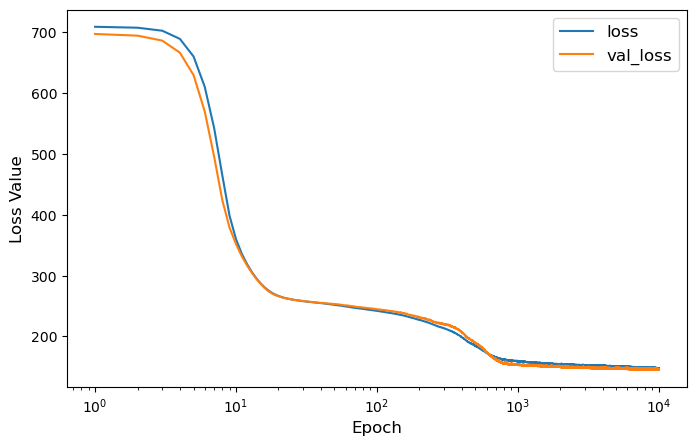

In [18]:
# plot losses against epoch number in log-scale
plt.figure(figsize=(8,5),dpi=100)
plt.semilogx(epoch, loss, linewidth=1.5, label='loss')
plt.semilogx(epoch, val_loss, linewidth=1.5, label='val_loss')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Loss Value',fontsize=12)
plt.legend(loc=1,fontsize=12)

Learning rate is OK; further training may be required

### Evaluation on Test Data

In [19]:
# predicted bike rental rate
y_pred = ann.predict(X_test)

Text(0, 0.5, 'Predicted value')

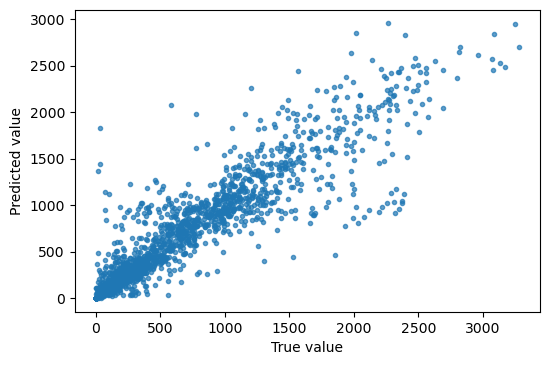

In [20]:
# plot of true rental rate against predicted value 
plt.figure(figsize=(6,4),dpi=100)
plt.plot(y_test.values,y_pred,'o',markersize=3,alpha=0.7)
plt.xlabel('True value')
plt.ylabel('Predicted value')

Text(0, 0.5, 'Probability Distribution')

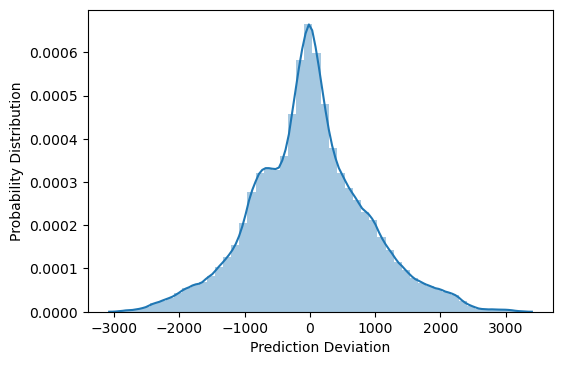

In [21]:
# distribution plot of prediction devations
plt.figure(figsize=(6,4),dpi=100)
sns.distplot(y_test.values-y_pred)
plt.xlabel('Prediction Deviation')
plt.ylabel('Probability Distribution')

Now we compute some performance metric in predicting the test values

In [22]:
from sklearn.metrics import explained_variance_score, r2_score

metric = {'value':[]}

# explained variance
exp_var = round(explained_variance_score(y_test,y_pred),3)
metric['value'].append(exp_var)

# R^2_score
r2 = round(r2_score(y_test,y_pred),3)
metric['value'].append(r2)

df_metric = pd.DataFrame(index=['explained_variance','R_squared'],
                         data=metric,
                         columns=['value'])

In [23]:
df_metric

,value
explained_variance,0.829
R_squared,0.829


Metric values are very good